In [ ]:
!pip install pytorch-forecasting -q
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import lightning.pytorch as pl
import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_forecasting.data.examples import generate_ar_data
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from torchsummary import summary

In [ ]:
wandb.init(project='Time_Series_exp', entity='lulim')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CFG:
  BATCH_SIZE = 32
print(device)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cuda


In [ ]:
# data = generate_ar_data(seasonality=10.0, timesteps=1000, n_series=2, seed=42)
data = generate_ar_data(seasonality=10.0, timesteps=1000, n_series=2, trend=0.0, seed=42)
data['date'] = pd.Timestamp('2021-01-01') + pd.to_timedelta(data['time_idx'], 'D')

plt.plot(data.loc[:1000, 'date'], data.loc[:1000, 'value'])

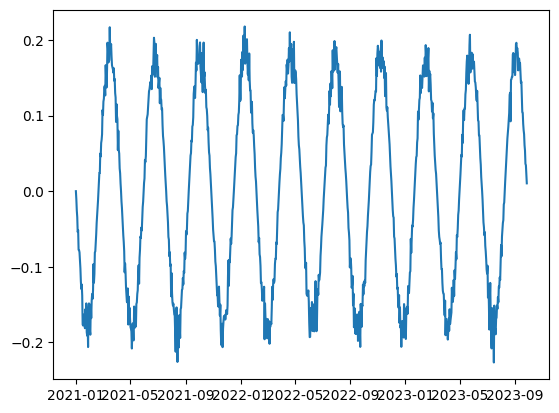

In [ ]:
plt.plot(data.loc[1000:, 'date'], data.loc[1000:, 'value'])

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        """
        Args:
            data (numpy.ndarray): The complete time series data.
            sequence_length (int): The length of the lookback window for creating sequences.
        """
        self.data = data
        self.sequence_length = sequence_length
        self.total_sequences = len(data) - sequence_length

    def __len__(self):
        return self.total_sequences

    def __getitem__(self, index):
        # Retrieve the sequence from index to index + sequence_length
        sequence = self.data[index:index + self.sequence_length]
        # Retrieve the target value right after the sequence
        target = self.data[index + self.sequence_length]

        # Convert numpy arrays to torch tensors
        sequence = torch.tensor(sequence, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        return sequence, target

In [ ]:
print(data.head())

   series  time_idx     value       date
0       0         0  0.000000 2021-01-01
1       0         1 -0.021994 2021-01-02
2       0         2 -0.039698 2021-01-03
3       0         3 -0.059305 2021-01-04
4       0         4 -0.084494 2021-01-05


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# train_test_split by time series (test_size=0.25)
train_df = data.loc[:0.75*1000, 'value'].to_numpy()
test_df = data.loc[0.75*1000:, 'value'].to_numpy()

train_ds = TimeSeriesDataset(data=train_df, sequence_length=10)
test_ds = TimeSeriesDataset(data=test_df, sequence_length=10)

train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True) #shuffle=False?
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
class SimpleModelCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
      super().__init__()
      self.block1 = nn.Sequential(
          nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.GELU(),
          nn.MaxPool1d(kernel_size=2),
          # nn.LayerNorm(normalized_shape=(32, 1))
      )
      self.block2 = nn.Sequential(
          nn.Conv1d(in_channels=32, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
          nn.GELU(),
          nn.MaxPool1d(kernel_size=2),
          # nn.LayerNorm(normalized_shape=(hidden_size, 1))
      )
      self.fc1 = nn.Sequential(
        nn.Linear(in_features=192, out_features=32),
        nn.GELU()
      )
      self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
      x = x.transpose(1, 2) # Change input from (batch_size, seq_len, features) to (batch_size, features, seq_len)
      x = self.block1(x)
      x = self.block2(x)
      x = x.view(x.size(0), -1)
      # x.size == (1, 128)
      x = self.fc1(x)
      x = self.fc2(x)
      return x

In [ ]:
import gc

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    lambda1 = lambda num_epochs: num_epochs // 30
    lambda2 = lambda num_epochs: 0.95 ** num_epochs
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda2])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    model.train()

    train_losses = []
    val_losses = []

    for i, epoch in enumerate(tqdm(range(num_epochs))):
        train_loss = 0
        val_loss = 0

        for i, (inputs, targets) in enumerate(tqdm(train_loader)):
            model.train()
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            #loss = criterion(outputs, targets)
            loss = torch.sqrt(criterion(outputs, targets)) #!
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        with torch.no_grad():
            model.eval()
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        gc.collect()

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'learning_rate': scheduler.get_last_lr()[0]
        })

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        # Visualize training and validation loss
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

In [ ]:
def get_sequence(dataset: np.array, sequence_len: int = 14, horizont: int = 1):
  X, y = [], []
  n = len(dataset)
  for i in range(n - sequence_len - 1):
    X.append(dataset[i:i + sequence_len])
    y.append(dataset[i + sequence_len])
  X, y = np.array(X), np.array(y)
  X, y = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
  return X, y

In [ ]:
model = SimpleModelCNN(input_size=14, hidden_size=64, output_size=CFG.BATCH_SIZE, num_layers=1) #?
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_loss = train_loop(model, train_loader, criterion, optimizer, 0, 50)

  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


  0%|          | 0/49 [00:00<?, ?it/s]

torch.Size([32, 1]) torch.Size([32, 1])


Text(0, 0.5, 'MSELoss')

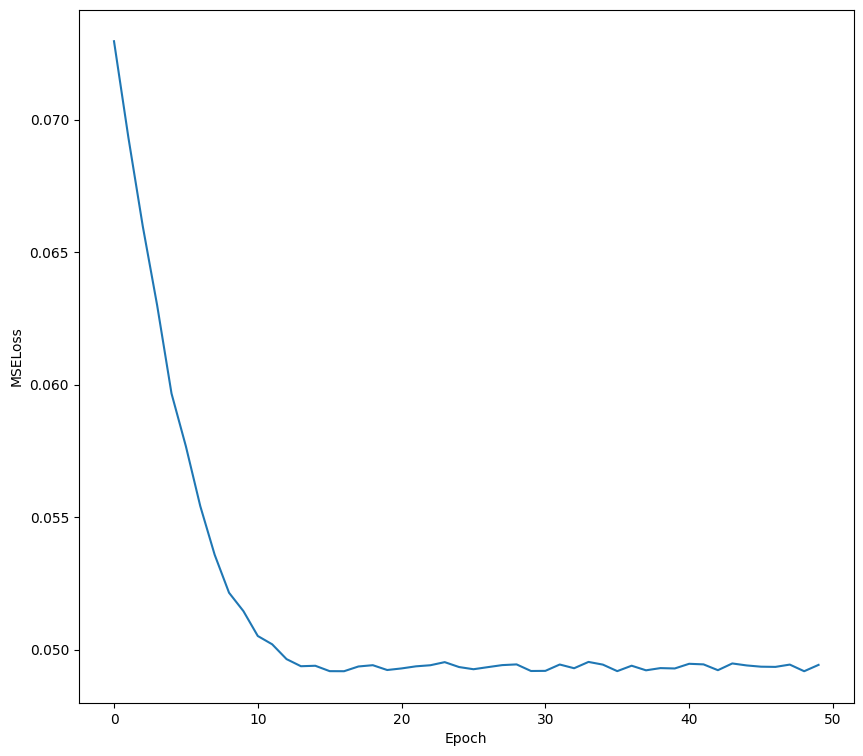

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

In [ ]:
def forecast(model, data, steps_ahead):
    model.eval()
    with torch.no_grad():
        # Prepare input data
        outputs = []
        input = data[0].cpu().unsqueeze(0) # Add batch and channel dimensions
        input.detach().clone()

        for i in range(steps_ahead):
            if i > 0:
              # print(data[i])
              input = data[i].cpu().unsqueeze(0)
              # print(input)
              input.detach().clone()
              input[-1, -1] = outputs[-1]
            # input = scaler.transform(input)
            print(input.size())
            input = input.to(device)
            output = model(input).cpu().detach()
            print(f'{i}: {outputs}, {output}')
            # output = scaler.inverse_transform(output.reshape(-1, 1)) # Reverse scaling
            # print(output)
            print('=====')
            outputs.append(output.item())


        return outputs

def plot_forecast(real_values, predicted_values):
    plt.figure(figsize=(10, 5))
    plt.plot(real_values, label='Real values')
    plt.plot(predicted_values, label='Predicted values')
    plt.title('Forecasting Time Series')
    plt.xlabel('Time steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [ ]:
test_dataset[-15:][1]

tensor([[0.1698],
        [0.1557],
        [0.1433],
        [0.1450],
        [0.1227],
        [0.1044],
        [0.1039],
        [0.0891],
        [0.0807],
        [0.0754],
        [0.0609],
        [0.0538],
        [0.0362],
        [0.0344],
        [0.0225]])

i=1, tensor([0.1698])
i=2, tensor([0.1557])
i=3, tensor([0.1433])
i=4, tensor([0.1450])
i=5, tensor([0.1227])
i=6, tensor([0.1044])
i=7, tensor([0.1039])
i=8, tensor([0.0891])
i=9, tensor([0.0807])
i=10, tensor([0.0754])
i=11, tensor([0.0609])
i=12, tensor([0.0538])
i=13, tensor([0.0362])
i=14, tensor([0.0344])


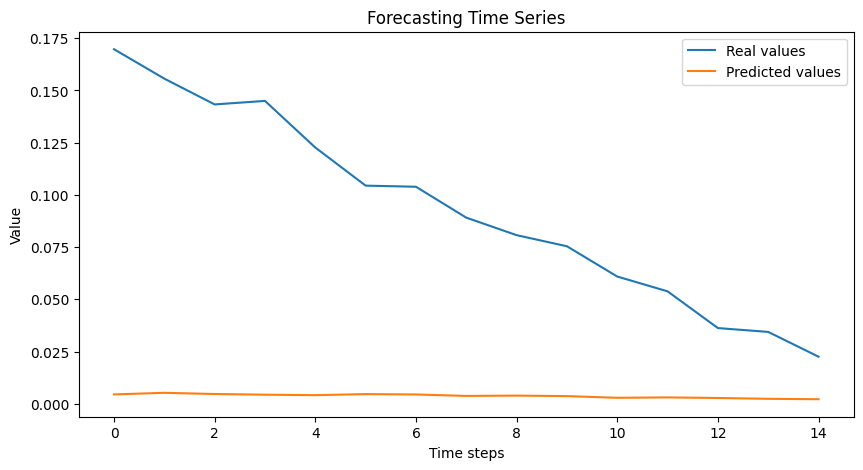

In [ ]:
input_data, real_value = test_dataset[-15:]  # Last 15 steps as input
real_value = real_value.numpy()
predicted_values = forecast(model, input_data, steps_ahead=15)
plot_forecast(real_value, predicted_values)

In [ ]:
print(predicted_values)

[0.004454627633094788, 0.005225867033004761, 0.004655763506889343, 0.004329368472099304, 0.004103139042854309, 0.004604429006576538, 0.004428863525390625, 0.003740951418876648, 0.003886863589286804, 0.003647938370704651, 0.0028470903635025024, 0.003021642565727234, 0.0027453452348709106, 0.0023505836725234985, 0.002158835530281067]


In [ ]:
import torch
import torch.nn as nn

class PowerfulCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, kernel_size=3, dropout=0.2):
        super(PowerfulCNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.dropout = dropout

        # Convolutional Layers with increasing channels
        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for i in range(self.num_layers):
            out_channels = 2**(i+1)
            layer = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(out_channels),
                nn.GELU(),
                nn.MaxPool1d(kernel_size=2, stride=1) if i < num_layers - 1 else nn.Identity(),  # Apply MaxPool to all except the last layer
                nn.Dropout(self.dropout)
            )
            self.conv_layers.append(layer)
            in_channels = out_channels  # Update in_channels for next layer

        # Calculate the output size after the convolutional layers
        # conv_output_size = self.input_size
        # for i in range(self.num_layers-1):
        #   conv_output_size = (conv_output_size + 2*(self.kernel_size//2) - (self.kernel_size-1) -1 ) // 2 + 1

        # conv_output_size *= 2**self.num_layers
        # Calculate conv_output_size with a test tensor
        with torch.no_grad():
            test_tensor = torch.randn(1, 1, input_size)  # Sample input
            for layer in self.conv_layers:
                test_tensor = layer(test_tensor)
            conv_output_size = torch.flatten(test_tensor, 1).shape[1]

        self.conv_output_size = conv_output_size

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(conv_output_size, self.hidden_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        # Convolutional layers
        for layer in self.conv_layers:
            x = layer(x)
            # print(x.shape)
        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1)
        # print(x.size(), self.conv_output_size)

        # Fully Connected layers
        x = self.fc(x)
        return x



In [ ]:
import torch
import torch.nn as nn

class PowerfulCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, kernel_size=3, dropout=0.2):
        super(PowerfulCNN_LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.dropout = dropout

        # Convolutional Layers with increasing channels
        self.conv_layers = nn.ModuleList()
        in_channels = 1
        for i in range(self.num_layers):
            out_channels = 2**(i+1)
            layer = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=1) if i < num_layers - 1 else nn.Identity(),  # Apply MaxPool to all except the last layer
                nn.Dropout(self.dropout)
            )
            self.conv_layers.append(layer)
            in_channels = out_channels  # Update in_channels for next layer

        with torch.no_grad():

            test_tensor = torch.randn(1, 1, input_size)  # Sample input
            for layer in self.conv_layers:
                layer.eval()
                test_tensor = layer(test_tensor)
            conv_output_size = torch.flatten(test_tensor, 1).shape[1]

        self.conv_output_size = conv_output_size

        # LSTM layer
        self.lstm = nn.LSTM(conv_output_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = x.transpose(1, 2)

        # Convolutional layers
        for layer in self.conv_layers:
            x = layer(x)

        # Flatten the output from convolutional layers
        x = x.view(x.size(0), -1, self.conv_output_size)

        # LSTM layer
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the last output of LSTM

        # Fully Connected layers
        x = self.fc(lstm_out)

        return x

## TCN Experiments

In [ ]:
from google.colab import drive
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
scaler = StandardScaler()

df = pd.read_csv('/content/drive/MyDrive/time_series_datasets/Daily-train.csv')
df.head()

V1       V2       V3       V4       V5       V6       V7       V8       V9  \
0  D1  1017.10  1019.30  1017.00  1019.20  1018.70  1015.60  1018.50  1018.30   
1  D2  2793.70  2793.80  2803.70  2805.80  2802.30  2795.00  2806.40  2782.20   
2  D3  1091.30  1088.50  1085.70  1082.90  1080.10  1077.30  1074.50  1071.70   
3  D4  1092.00  1078.00  1064.00  1050.00  1036.00  1022.00  1008.00  1092.00   
4  D5  2938.63  2956.44  2964.41  2972.41  3014.97  3014.23  3024.08  3031.97   

      V10  ...  V9911  V9912  V9913  V9914  V9915  V9916  V9917  V9918  V9919  \
0  1018.4  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1  2780.3  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2  1068.9  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3  1078.0  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4  3062.7  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   V9920  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

[5 rows x 9920 columns]

In [ ]:
import plotly.express as px


df = df.loc[:, 'V1': 'V10']
fig = px.line(df, y='V3')
fig.show()

In [ ]:
data = df[['V3']]
print(data.shape)
data.head()

(4227, 1)


V3
0  1019.30
1  2793.80
2  1088.50
3  1078.00
4  2956.44

In [ ]:
train_len = int(0.8 * len(data))
training_data = data.loc[:train_len, 'V3']
test_data = data.loc[train_len:, 'V3']

In [ ]:
dataset_train = np.reshape(training_data, (-1, 1))
dataset_test = np.reshape(test_data, (-1, 1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)
print(dataset_train.shape, dataset_test.shape)

(3382, 1) (846, 1)


In [ ]:
X_train, y_train = get_sequence(dataset_train, sequence_len=14)
print(X_train.size(), y_train.size())

X_test, y_test = get_sequence(dataset_test, sequence_len=14)
print(X_test.size(), y_test.size())

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, drop_last=True, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, drop_last=True, shuffle=False)

torch.Size([3367, 14, 1]) torch.Size([3367, 1])
torch.Size([831, 14, 1]) torch.Size([831, 1])


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.8827, Val Loss: 0.6576


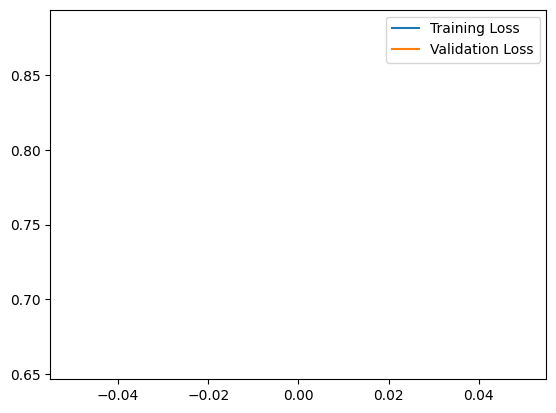

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 0.8423, Val Loss: 0.6676


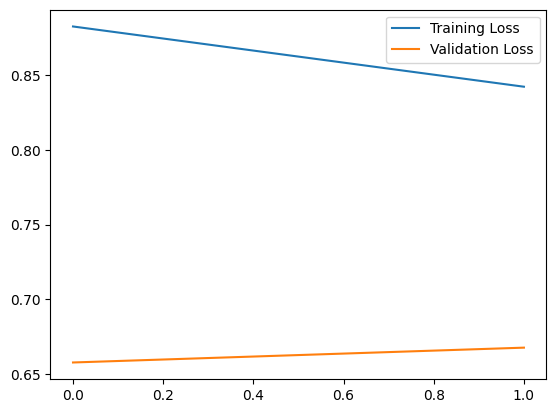

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 0.8476, Val Loss: 0.6626


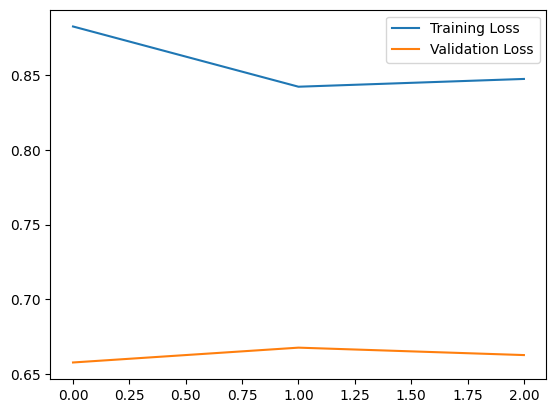

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 0.8435, Val Loss: 0.6743


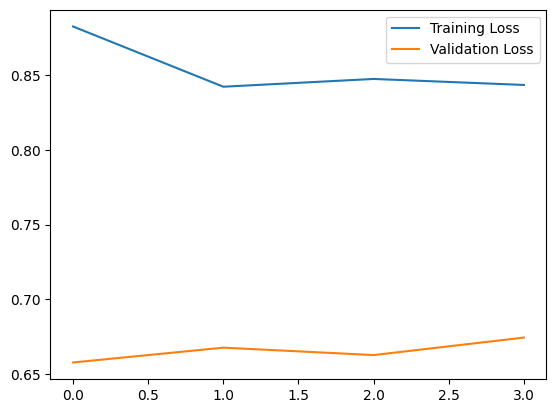

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 0.8410, Val Loss: 0.6551


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 0.8210, Val Loss: 0.6738


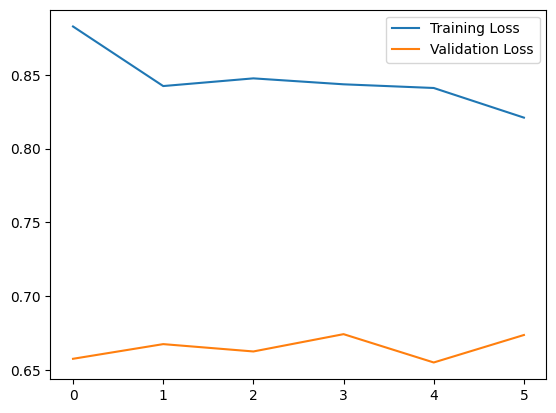

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 0.8106, Val Loss: 0.6417


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 0.8079, Val Loss: 0.6419


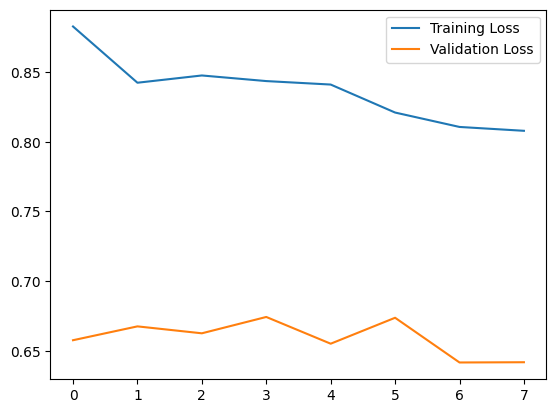

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 0.8099, Val Loss: 0.6112


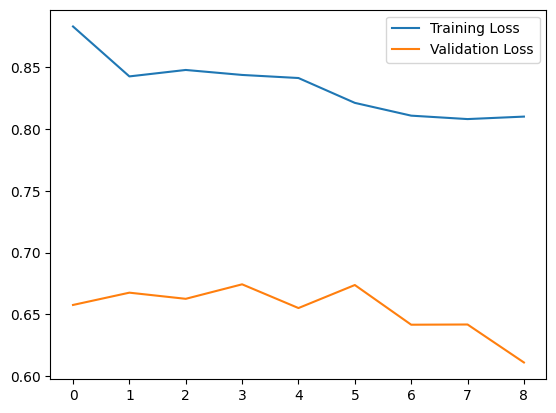

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 0.8020, Val Loss: 0.6262


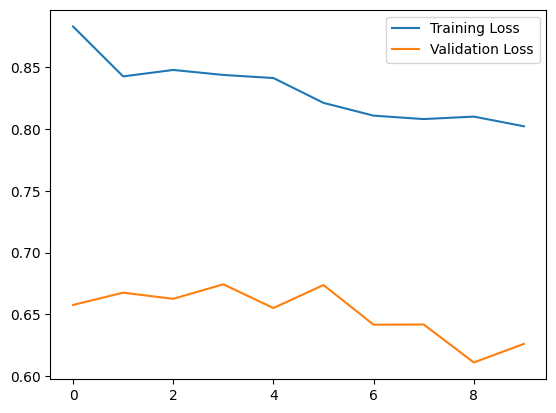

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.8097, Val Loss: 0.6242


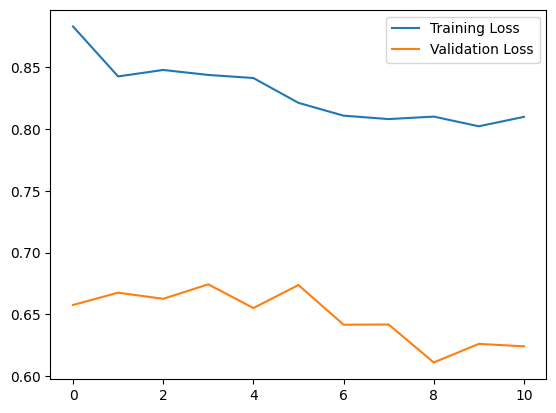

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.8050, Val Loss: 0.6192


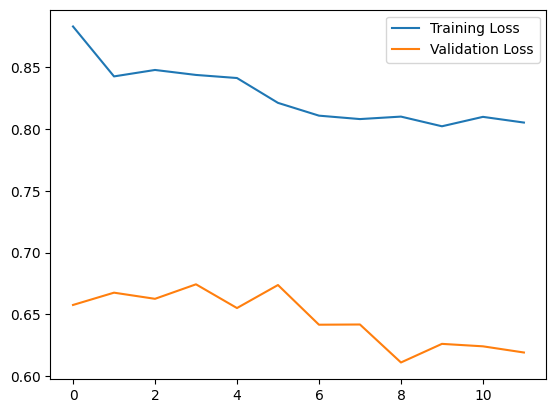

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.8122, Val Loss: 0.6262


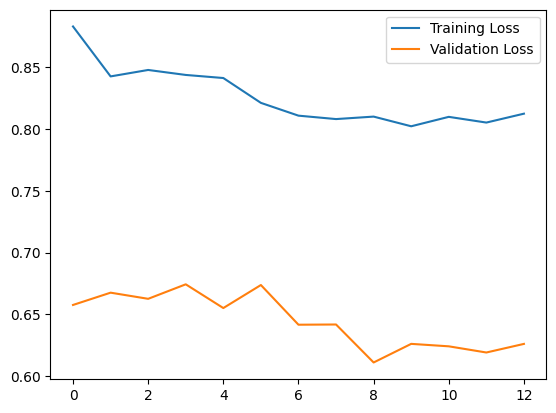

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.8040, Val Loss: 0.6234


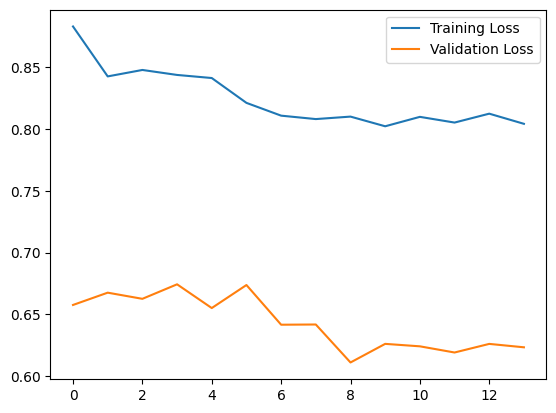

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.8096, Val Loss: 0.6169


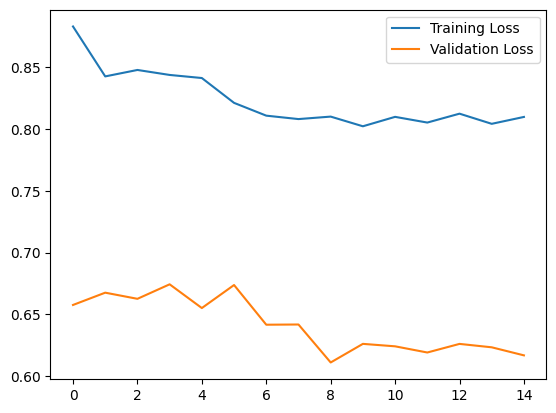

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.8020, Val Loss: 0.6114


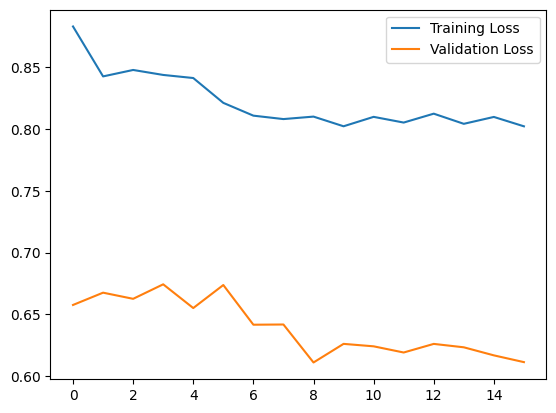

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.8071, Val Loss: 0.6180


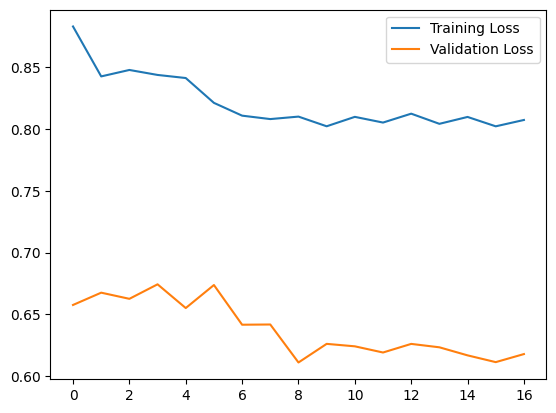

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.8120, Val Loss: 0.6172


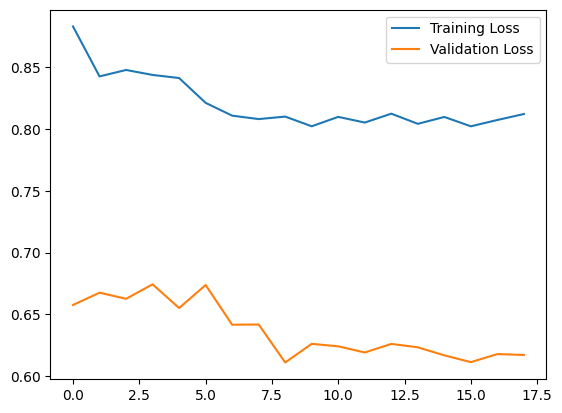

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.8048, Val Loss: 0.6151


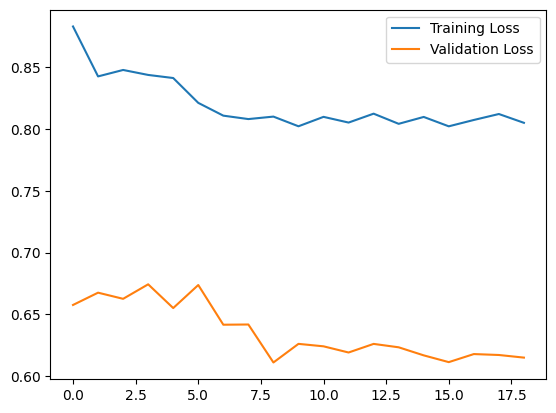

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.8067, Val Loss: 0.6224


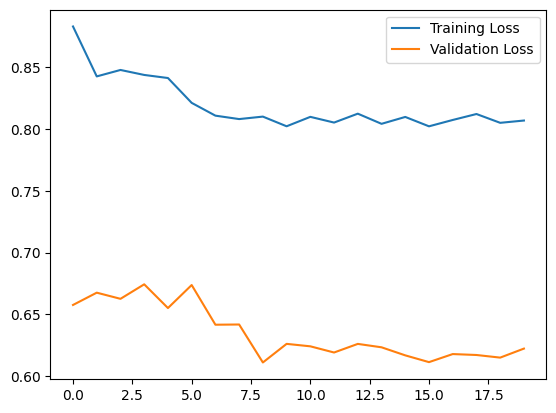

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.8075, Val Loss: 0.6089


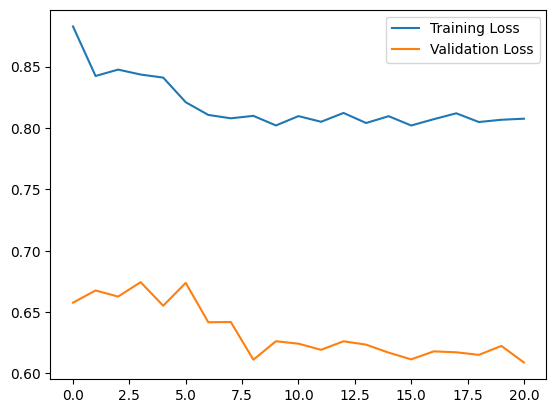

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.8073, Val Loss: 0.6175


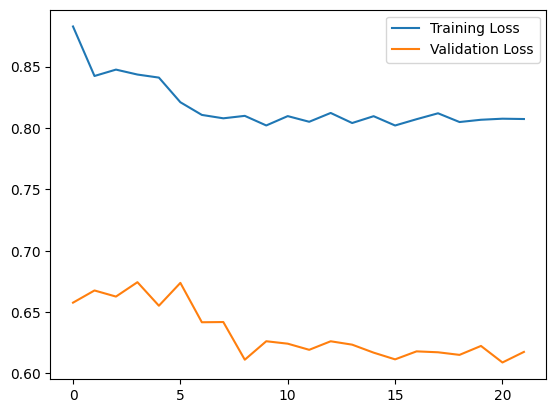

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.8029, Val Loss: 0.6132


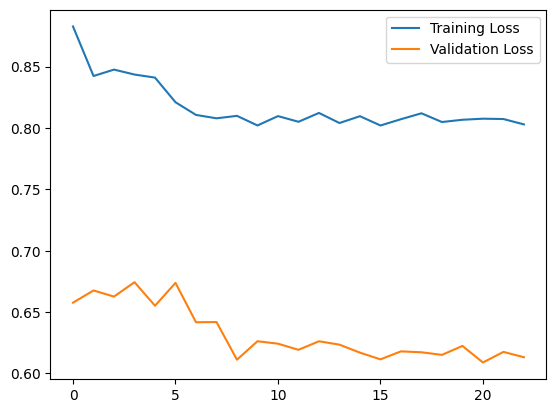

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.8080, Val Loss: 0.6123


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.8042, Val Loss: 0.6197


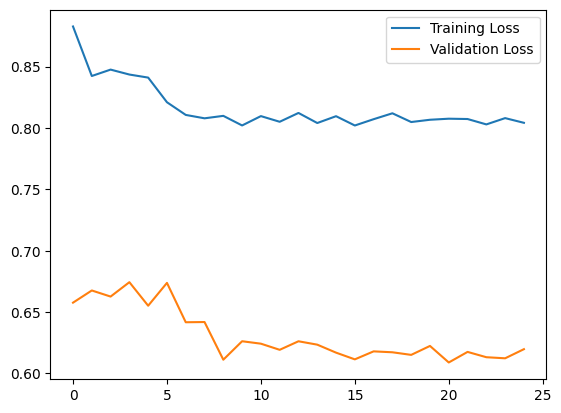

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.8093, Val Loss: 0.6190


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.8064, Val Loss: 0.6235


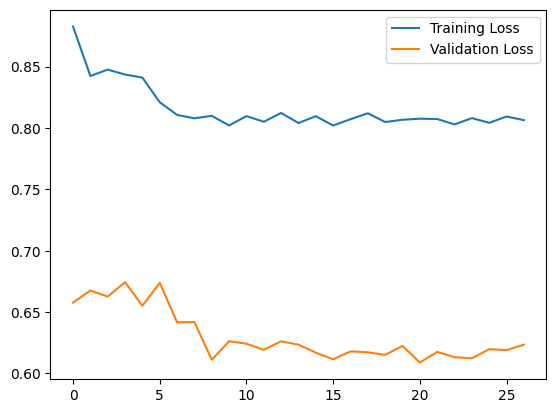

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.8075, Val Loss: 0.6128


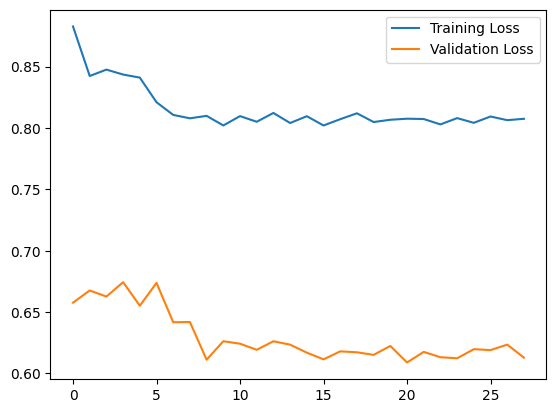

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.8069, Val Loss: 0.6237


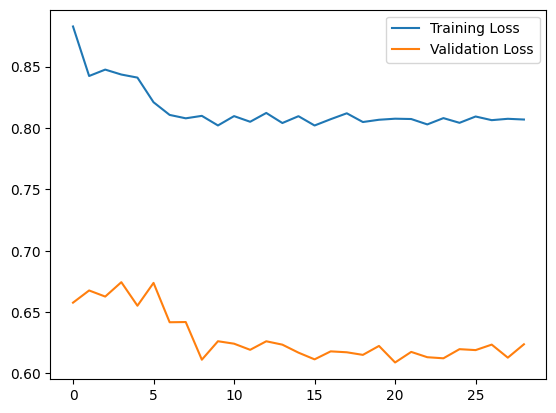

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.8059, Val Loss: 0.6181


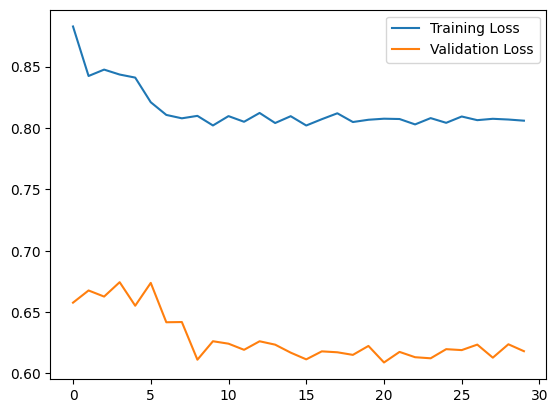

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.8043, Val Loss: 0.6234


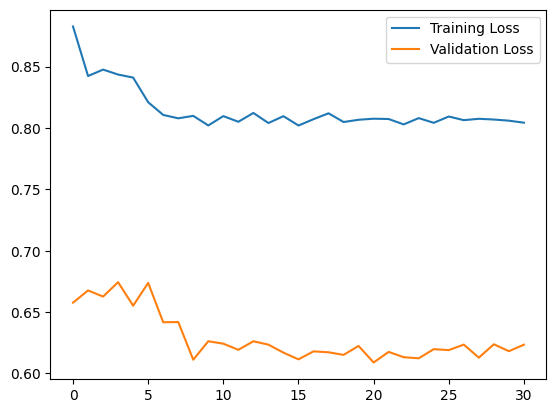

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.8077, Val Loss: 0.6176


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.8019, Val Loss: 0.6266


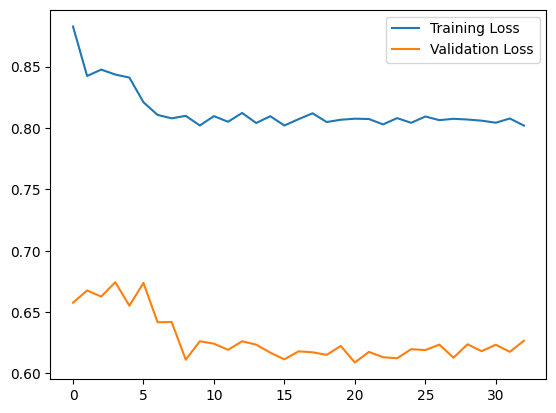

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.8051, Val Loss: 0.6203


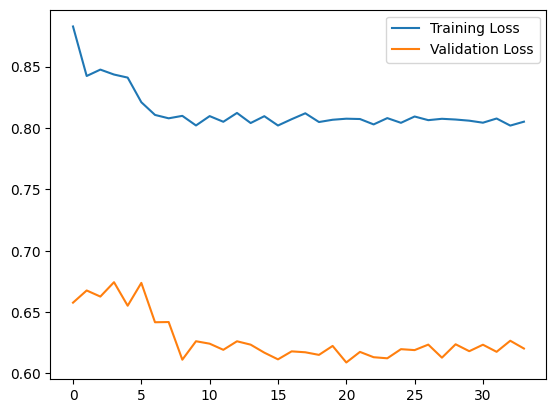

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.8064, Val Loss: 0.6179


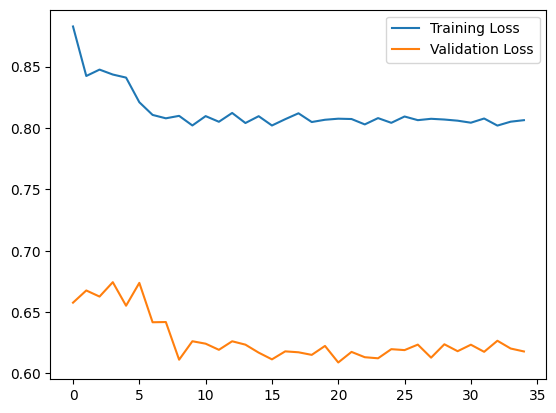

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.8031, Val Loss: 0.6227


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.8058, Val Loss: 0.6184


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.8119, Val Loss: 0.6245


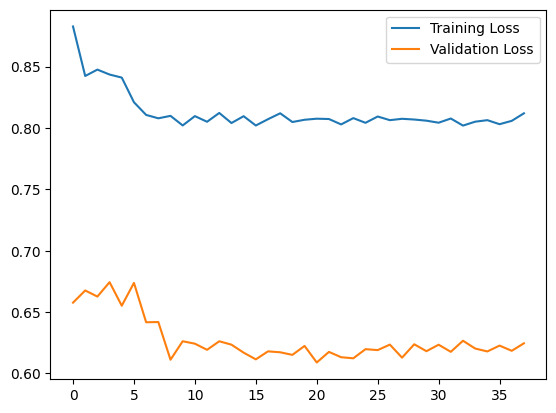

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.8079, Val Loss: 0.6151


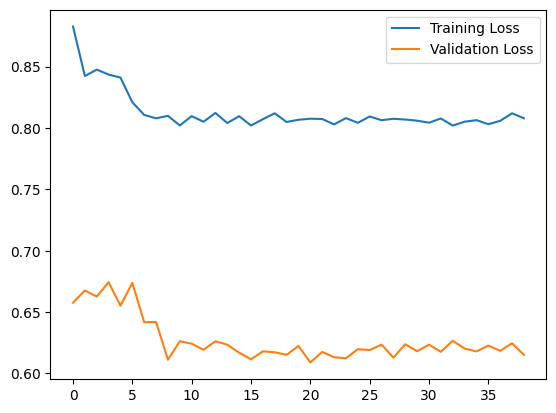

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.8057, Val Loss: 0.6209


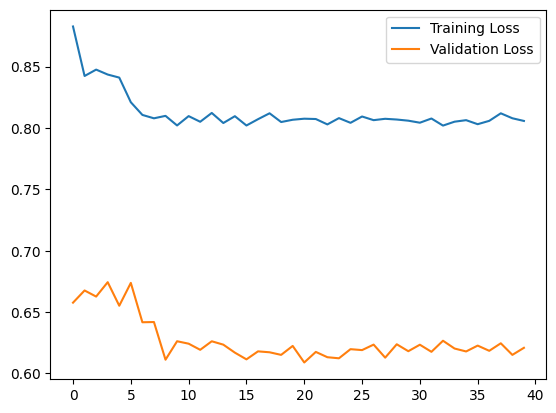

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.8102, Val Loss: 0.6201


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.8055, Val Loss: 0.6165


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.8034, Val Loss: 0.6120


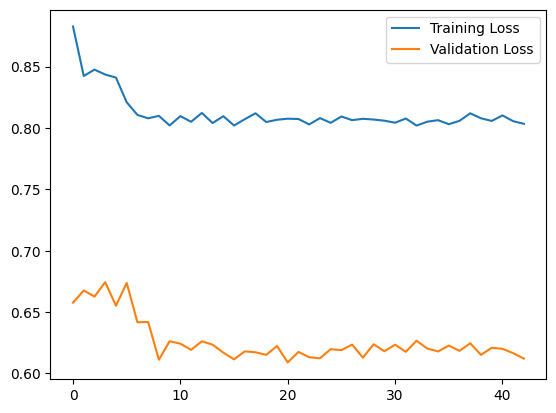

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.8112, Val Loss: 0.6183


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.8068, Val Loss: 0.6331


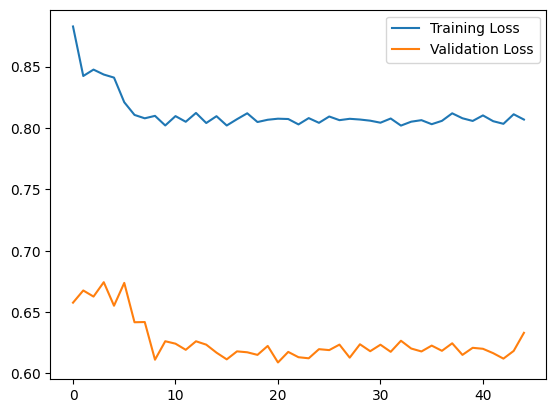

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.8089, Val Loss: 0.6216


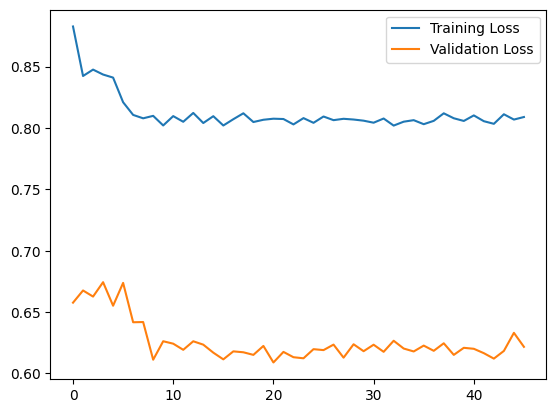

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.8008, Val Loss: 0.6245


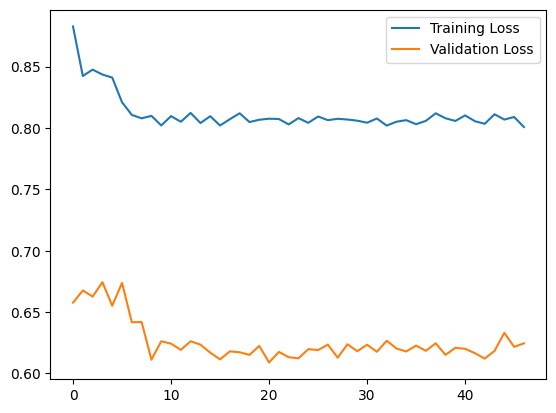

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.8041, Val Loss: 0.6124


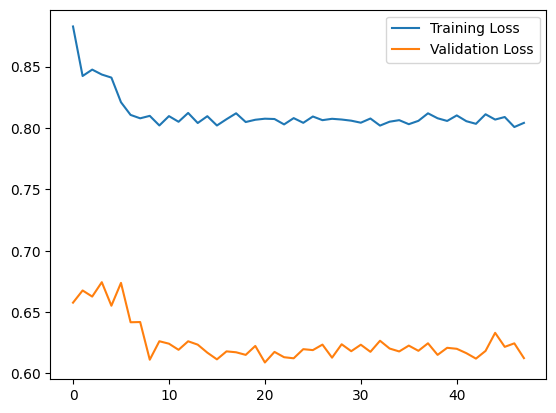

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.8025, Val Loss: 0.6228


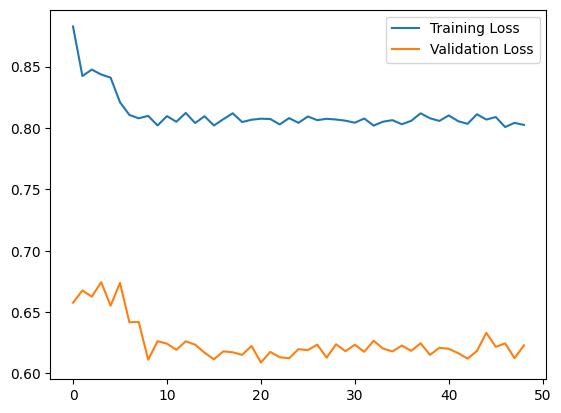

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.8068, Val Loss: 0.6117


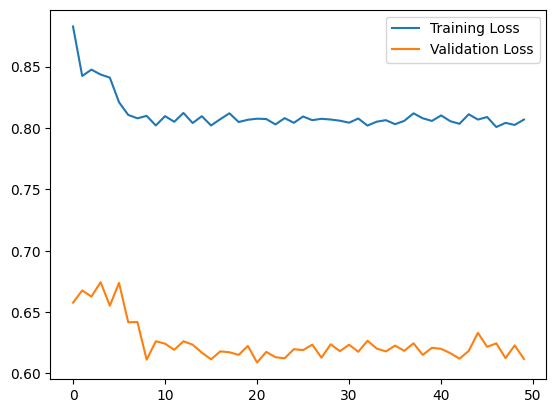

In [ ]:
model_power = PowerfulCNN(input_size=14,
                    hidden_size=128,
                    output_size=1,  # Predicting a single value (15th day)
                    num_layers=7,   # Example: 3 convolutional layers
                    kernel_size=3,
                    dropout=0.3).to(device)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model_power.parameters(), lr=1e-2)
train_loss_power, val_loss_power = train_model(model_power, criterion, optimizer, train_loader, test_loader, 50)

In [ ]:
gc.collect()

2214

In [ ]:
summary(model_power, (14, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 2, 14]               8
       BatchNorm1d-2                [-1, 2, 14]               4
              GELU-3                [-1, 2, 14]               0
         MaxPool1d-4                [-1, 2, 13]               0
           Dropout-5                [-1, 2, 13]               0
            Conv1d-6                [-1, 4, 13]              28
       BatchNorm1d-7                [-1, 4, 13]               8
              GELU-8                [-1, 4, 13]               0
         MaxPool1d-9                [-1, 4, 12]               0
          Dropout-10                [-1, 4, 12]               0
           Conv1d-11                [-1, 8, 12]             104
      BatchNorm1d-12                [-1, 8, 12]              16
             GELU-13                [-1, 8, 12]               0
        MaxPool1d-14                [-1

Text(0, 0.5, 'MSELoss')

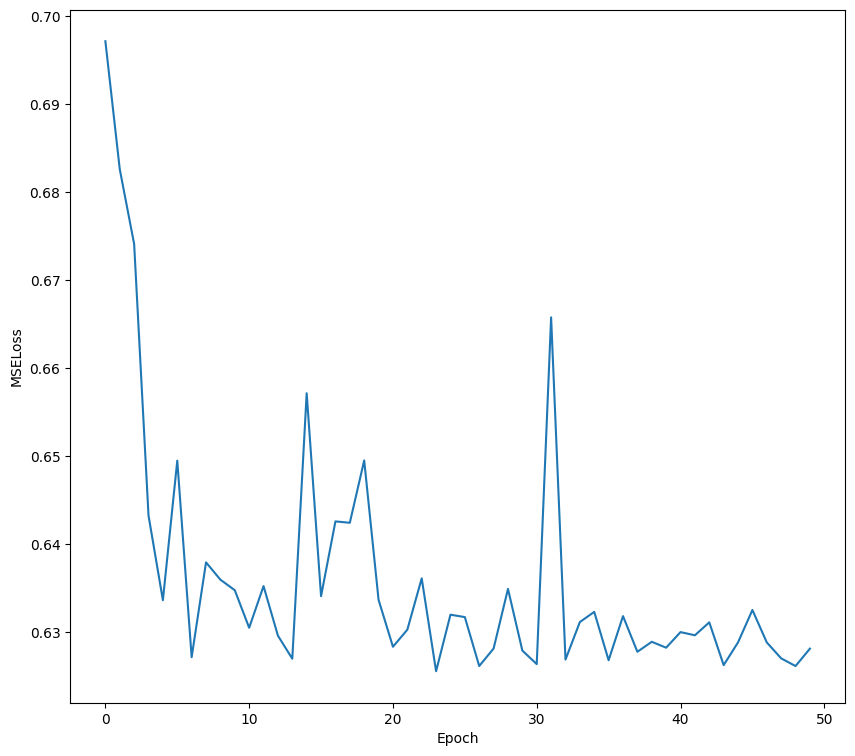

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(val_loss_power)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

In [ ]:
print(np.mean(val_loss_power))

0.6255017448782921


In [ ]:
input_data, real_value = test_dataset[-15:]  # Last 15 steps as input
real_value = real_value.numpy()
predicted_values = forecast(model_power, input_data, steps_ahead=15)
plot_forecast(real_value, predicted_values)

NameError: name 'model_power2' is not defined

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/50, Train Loss: 0.9864, Val Loss: 0.6860


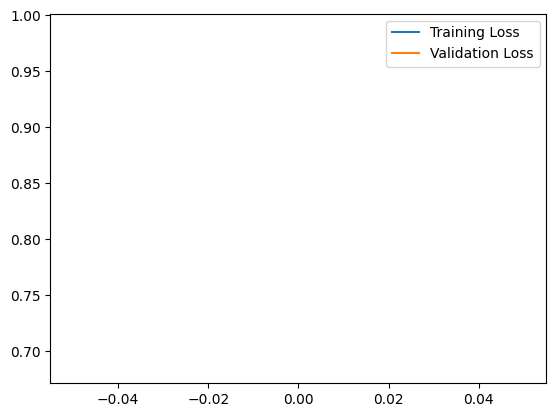

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/50, Train Loss: 0.9839, Val Loss: 0.6904


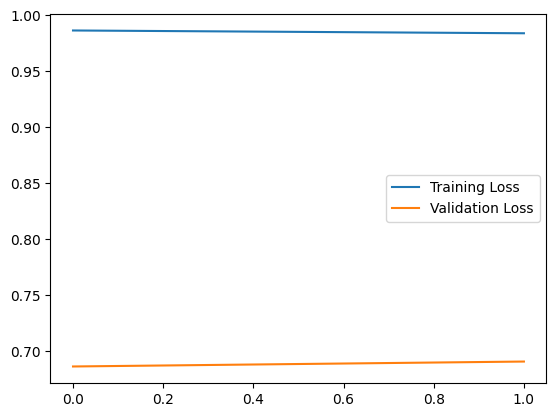

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/50, Train Loss: 0.9879, Val Loss: 0.6819


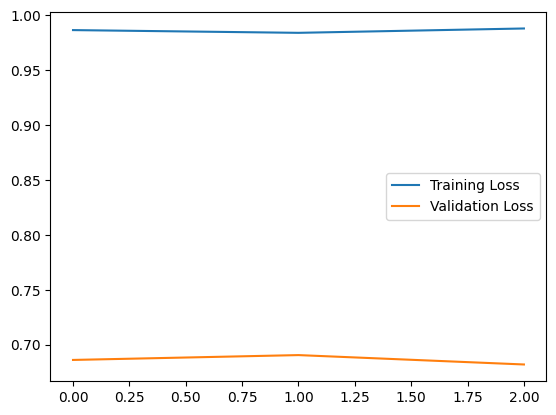

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/50, Train Loss: 0.9835, Val Loss: 0.6882


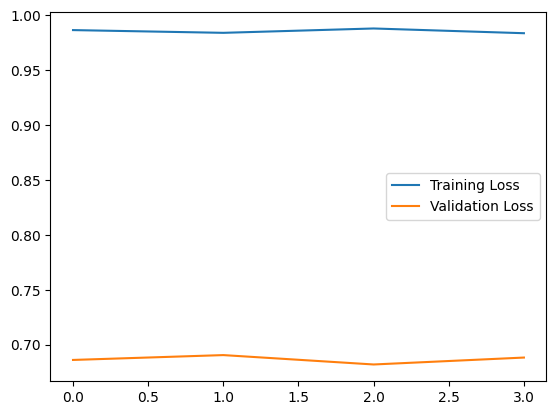

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/50, Train Loss: 0.9828, Val Loss: 0.6818


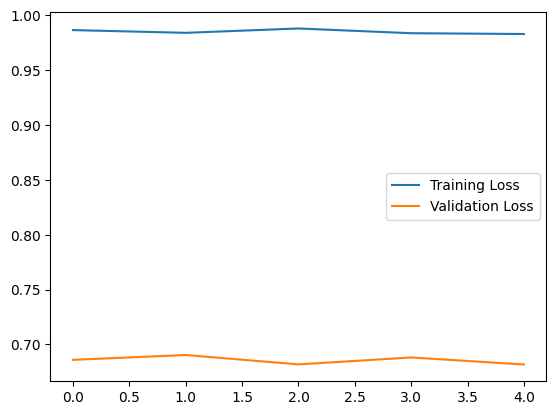

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/50, Train Loss: 0.9855, Val Loss: 0.6825


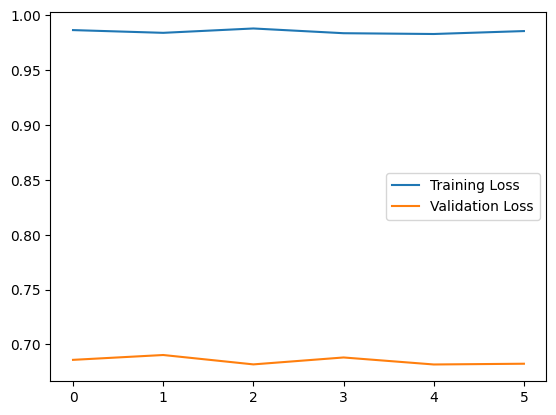

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/50, Train Loss: 0.9821, Val Loss: 0.6829


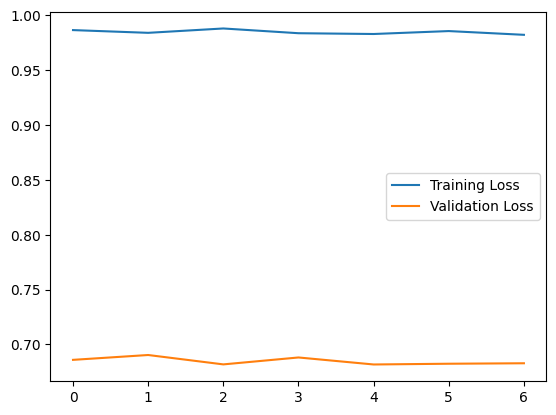

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/50, Train Loss: 0.9842, Val Loss: 0.6834


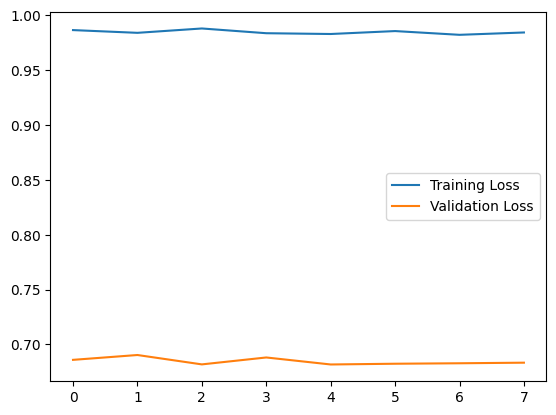

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/50, Train Loss: 0.9866, Val Loss: 0.6834


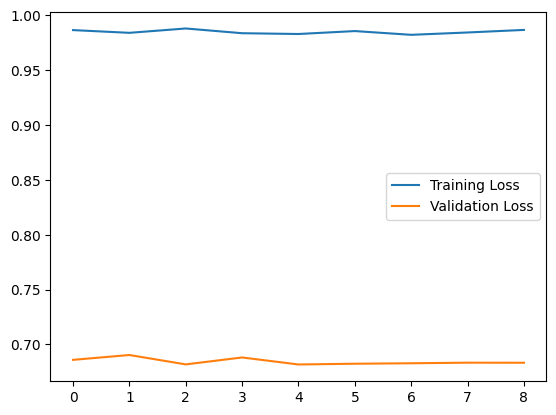

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/50, Train Loss: 0.9821, Val Loss: 0.6838


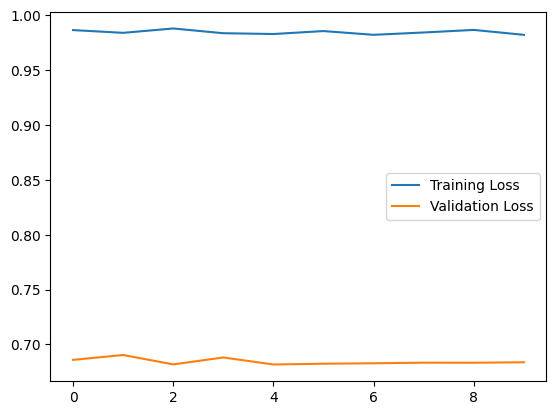

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/50, Train Loss: 0.9848, Val Loss: 0.6838


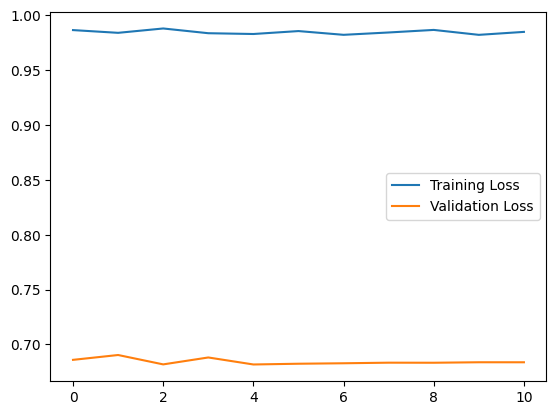

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/50, Train Loss: 0.9821, Val Loss: 0.6839


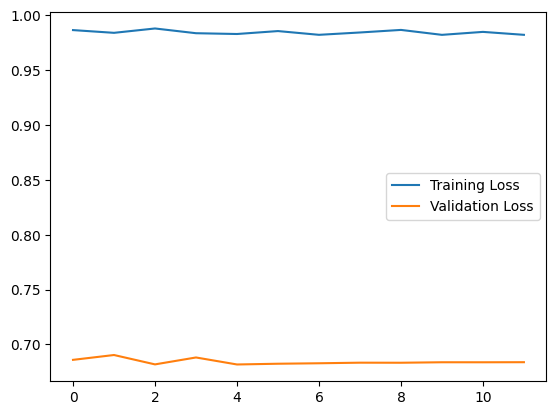

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/50, Train Loss: 0.9849, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/50, Train Loss: 0.9857, Val Loss: 0.6839


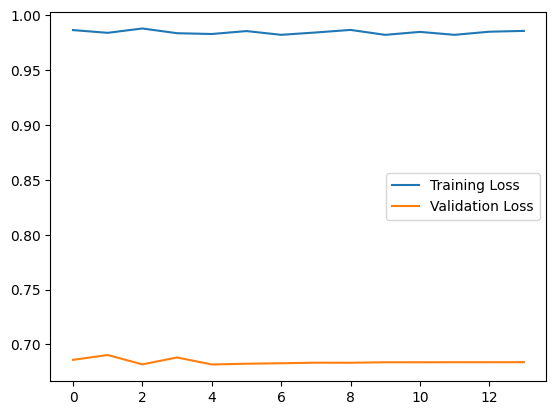

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/50, Train Loss: 0.9832, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/50, Train Loss: 0.9870, Val Loss: 0.6839


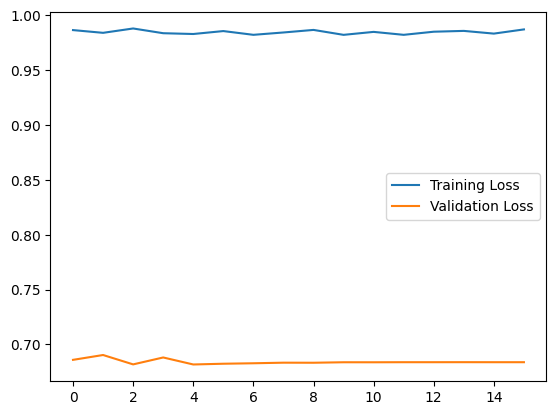

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/50, Train Loss: 0.9851, Val Loss: 0.6839


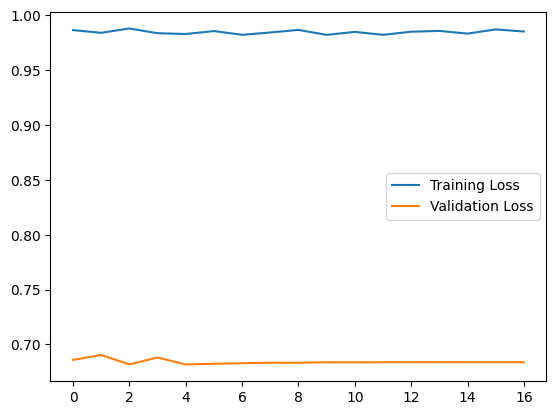

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/50, Train Loss: 0.9848, Val Loss: 0.6839


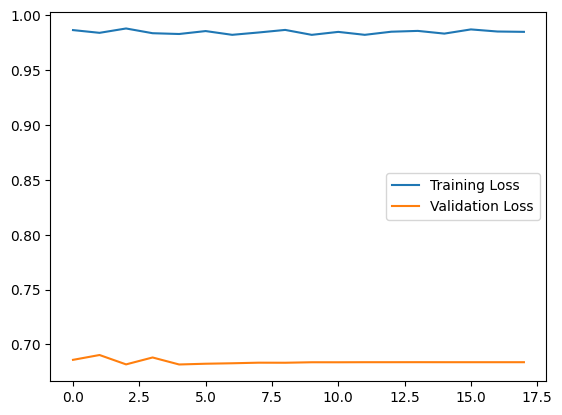

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/50, Train Loss: 0.9841, Val Loss: 0.6839


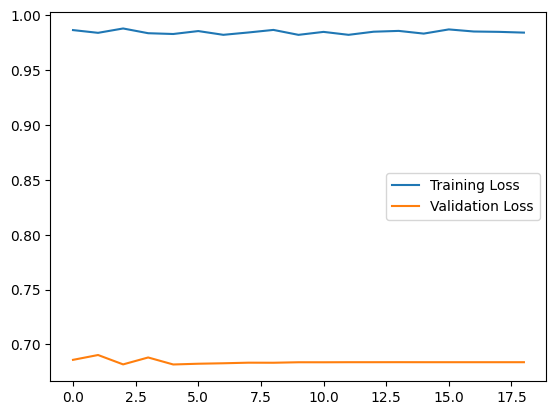

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/50, Train Loss: 0.9835, Val Loss: 0.6839


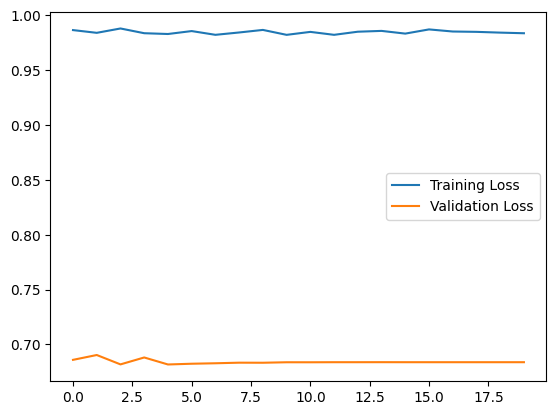

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/50, Train Loss: 0.9862, Val Loss: 0.6839


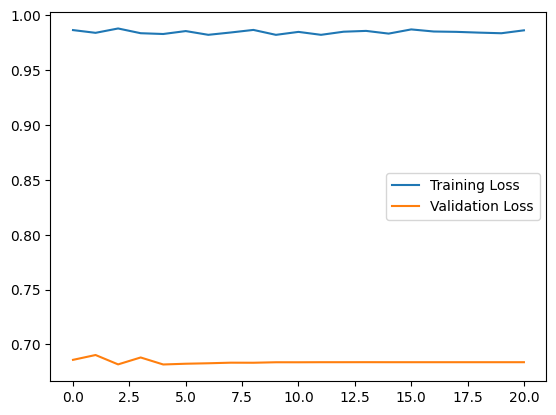

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/50, Train Loss: 0.9850, Val Loss: 0.6839


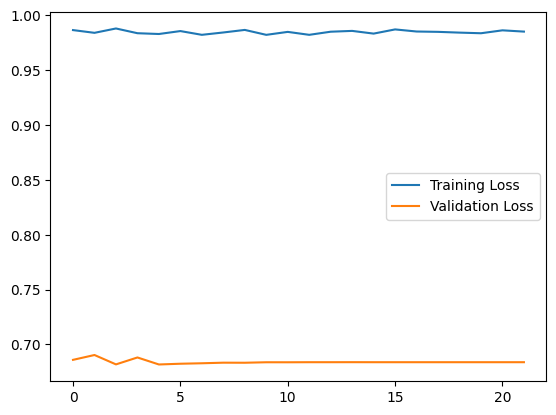

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/50, Train Loss: 0.9798, Val Loss: 0.6839


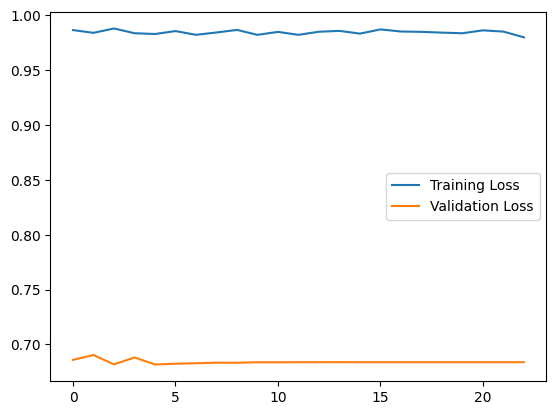

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/50, Train Loss: 0.9847, Val Loss: 0.6839


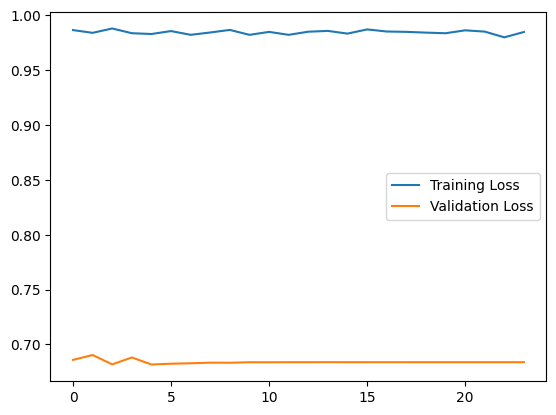

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/50, Train Loss: 0.9856, Val Loss: 0.6839


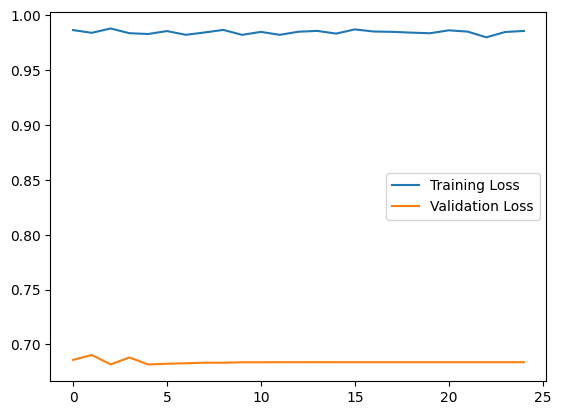

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/50, Train Loss: 0.9857, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/50, Train Loss: 0.9854, Val Loss: 0.6839


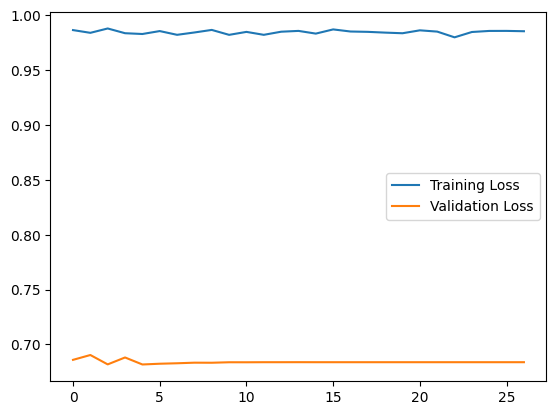

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/50, Train Loss: 0.9843, Val Loss: 0.6839


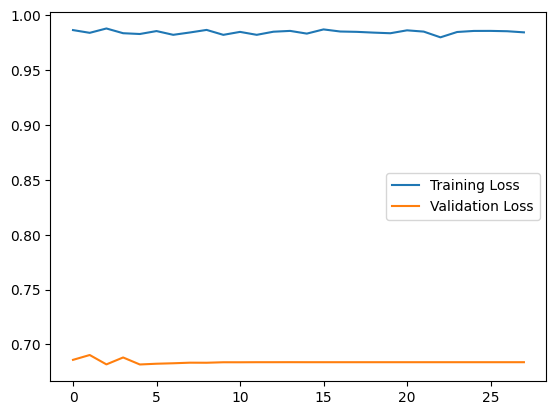

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/50, Train Loss: 0.9826, Val Loss: 0.6839


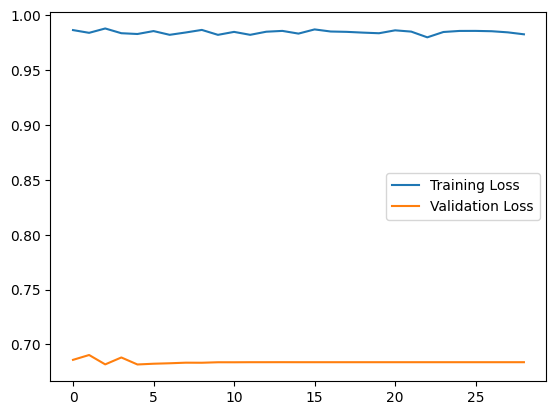

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/50, Train Loss: 0.9860, Val Loss: 0.6839


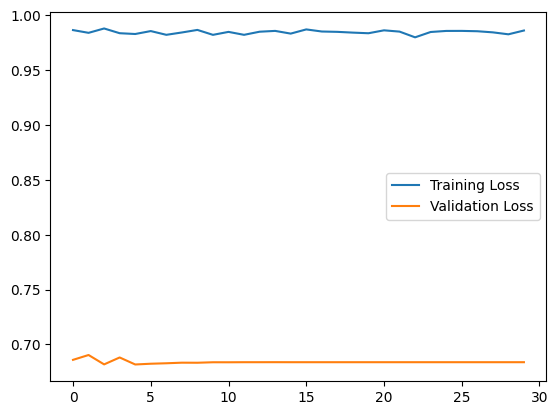

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/50, Train Loss: 0.9867, Val Loss: 0.6839


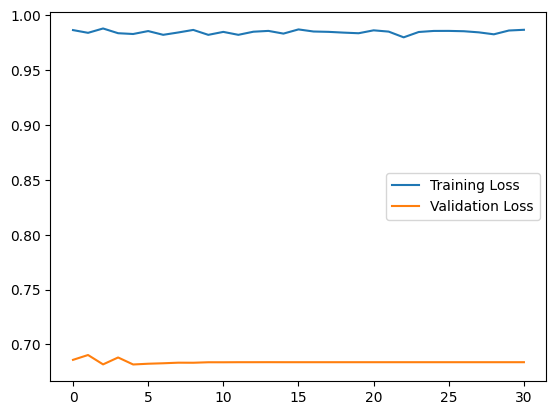

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/50, Train Loss: 0.9827, Val Loss: 0.6839


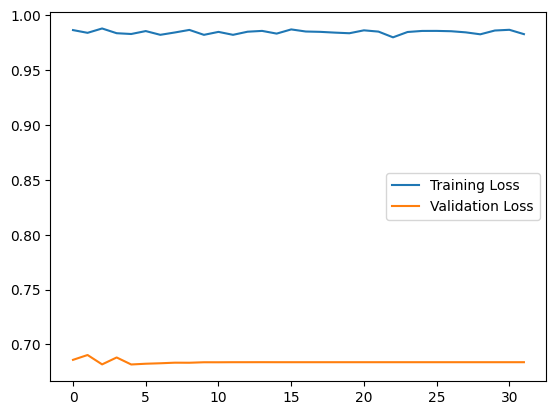

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/50, Train Loss: 0.9853, Val Loss: 0.6839


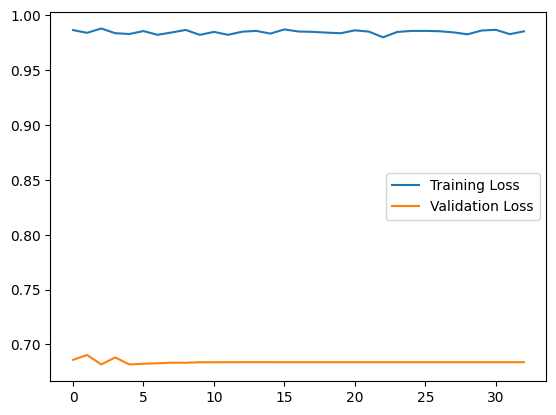

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/50, Train Loss: 0.9871, Val Loss: 0.6839


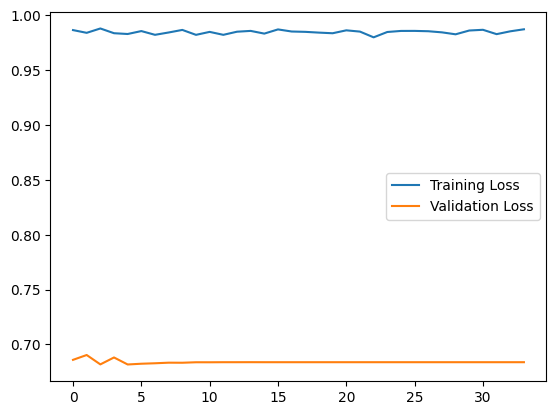

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/50, Train Loss: 0.9807, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 36/50, Train Loss: 0.9852, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 37/50, Train Loss: 0.9843, Val Loss: 0.6839


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 38/50, Train Loss: 0.9819, Val Loss: 0.6839


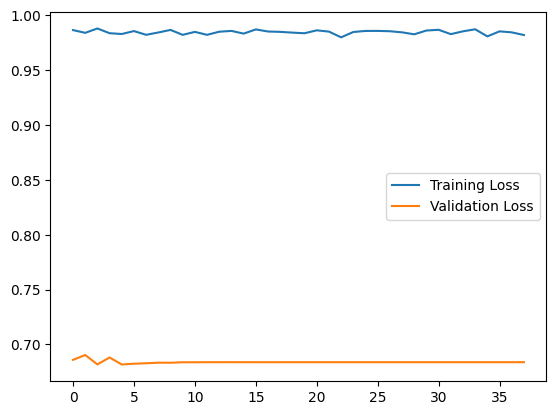

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 39/50, Train Loss: 0.9852, Val Loss: 0.6839


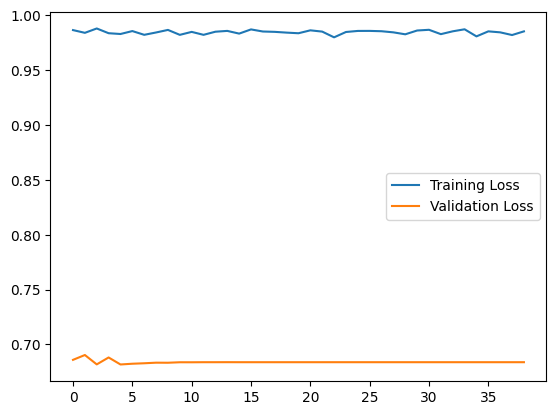

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 40/50, Train Loss: 0.9847, Val Loss: 0.6839


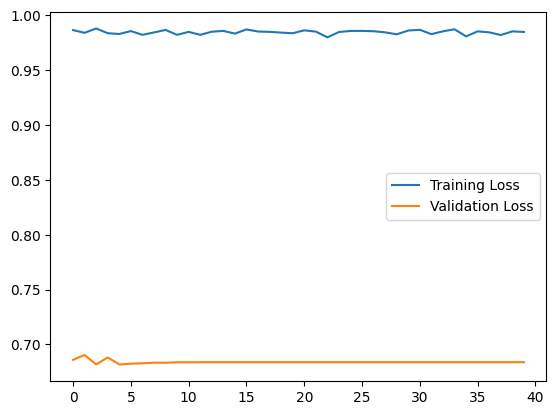

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 41/50, Train Loss: 0.9877, Val Loss: 0.6839


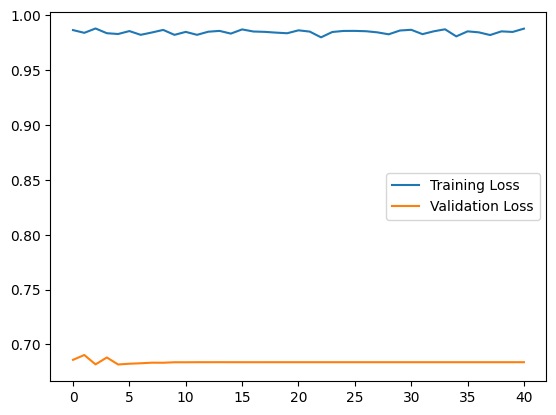

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 42/50, Train Loss: 0.9830, Val Loss: 0.6839


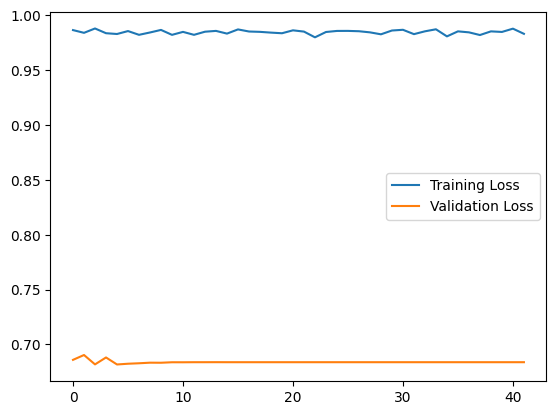

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 43/50, Train Loss: 0.9826, Val Loss: 0.6839


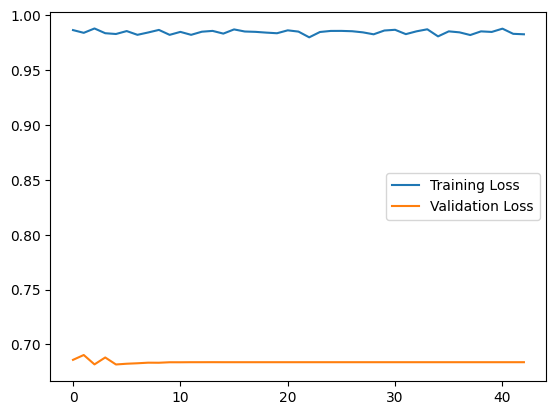

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 44/50, Train Loss: 0.9865, Val Loss: 0.6839


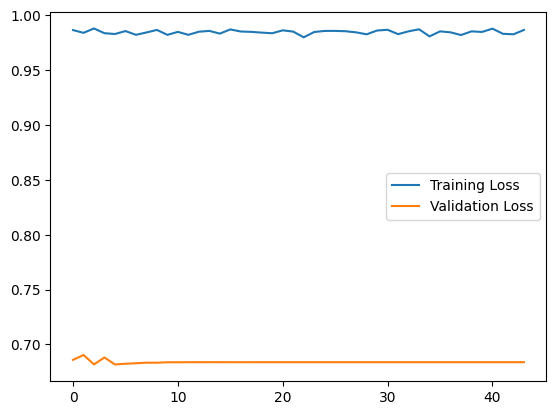

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 45/50, Train Loss: 0.9839, Val Loss: 0.6839


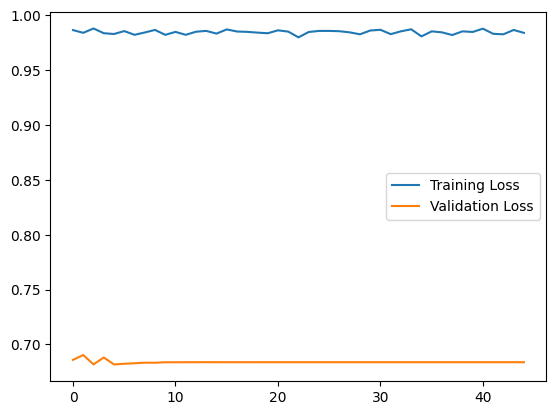

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 46/50, Train Loss: 0.9845, Val Loss: 0.6839


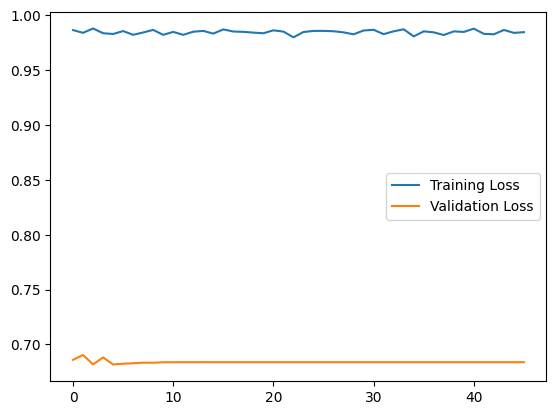

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 47/50, Train Loss: 0.9839, Val Loss: 0.6839


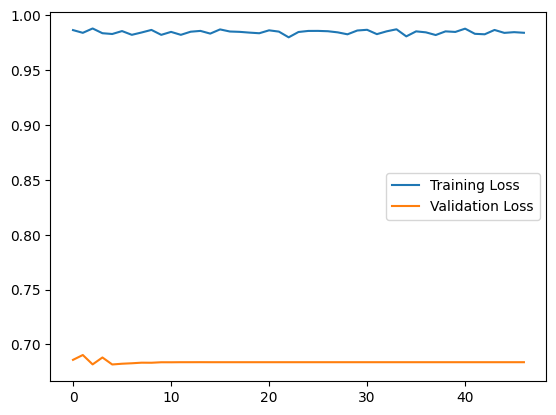

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 48/50, Train Loss: 0.9879, Val Loss: 0.6839


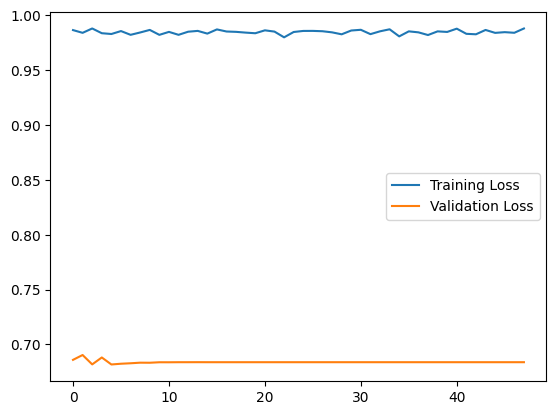

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 49/50, Train Loss: 0.9846, Val Loss: 0.6839


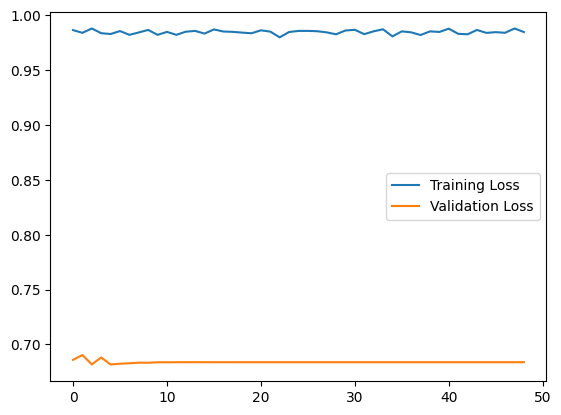

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 50/50, Train Loss: 0.9863, Val Loss: 0.6839


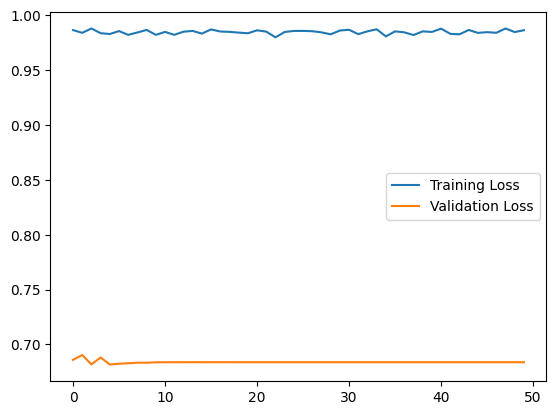

In [ ]:
model_power_lstm = PowerfulCNN_LSTM(input_size=14,
                    hidden_size=128,
                    output_size=1,  # Predicting a single value (15th day)
                    num_layers=13,   # Example: 3 convolutional layers
                    kernel_size=3,
                    dropout=0.3).to(device)
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_power_lstm.parameters(), lr=1e-3)
train_loss_lstm, val_loss_lstm = train_model(model_power_lstm, criterion, optimizer, train_loader, test_loader, num_epochs=50)

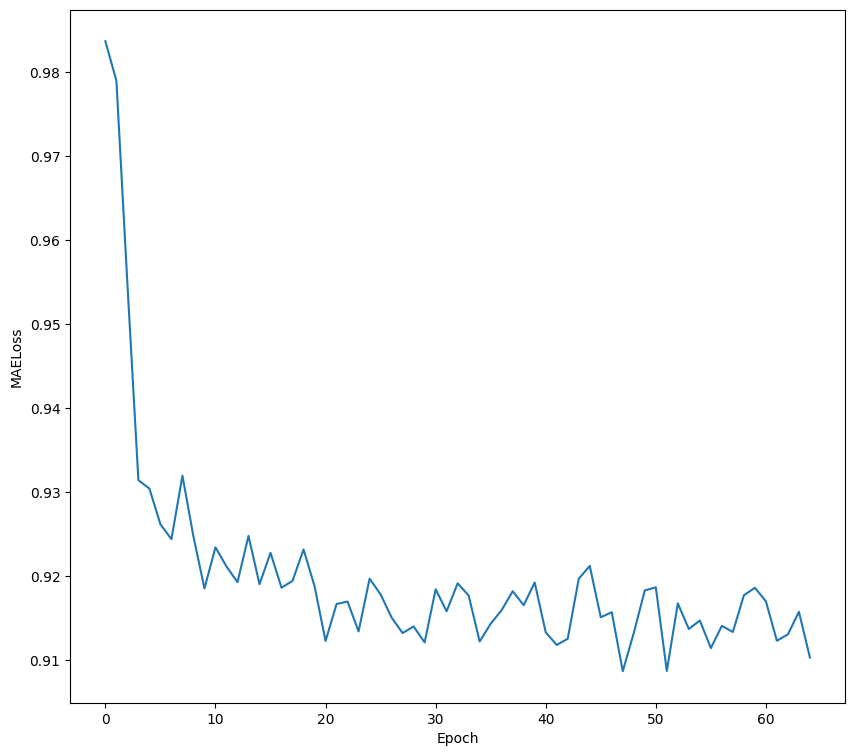

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(train_loss_lstm)
plt.xlabel('Epoch')
plt.ylabel('MAELoss')
plt.show()

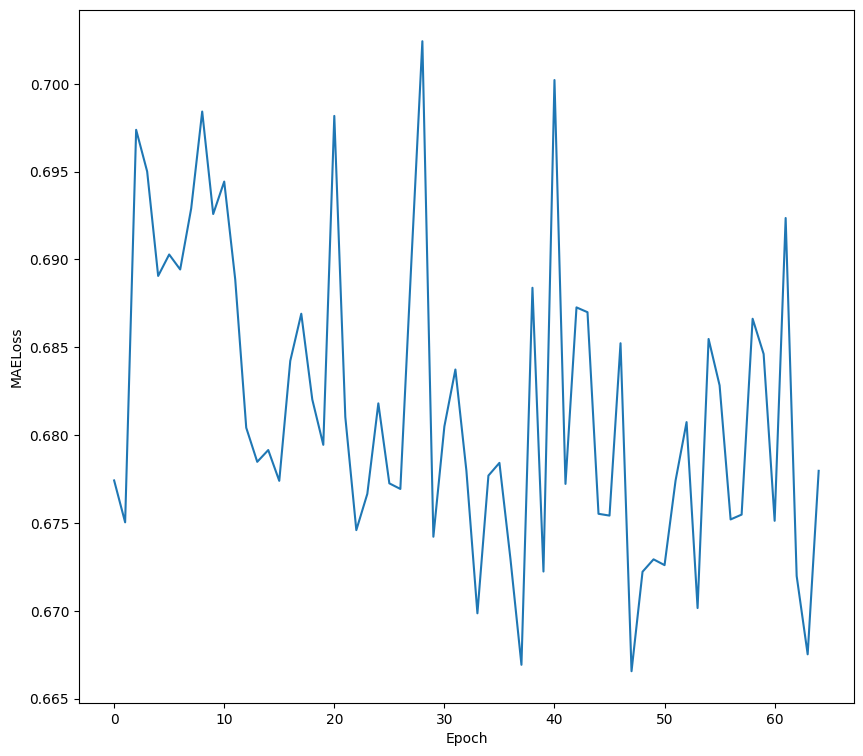

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(val_loss_lstm)
plt.xlabel('Epoch')
plt.ylabel('MAELoss')
plt.show()

In [ ]:
print(np.mean(val_loss_lstm))

0.6839793207764626


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model_power_lstm, input_size=(CFG.BATCH_SIZE, 14, 1))

Layer (type:depth-idx)                   Output Shape              Param #
PowerfulCNN_LSTM                         [32, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [32, 2, 13]               --
│    │    └─Conv1d: 3-1                  [32, 2, 14]               8
│    │    └─BatchNorm1d: 3-2             [32, 2, 14]               4
│    │    └─ReLU: 3-3                    [32, 2, 14]               --
│    │    └─MaxPool1d: 3-4               [32, 2, 13]               --
│    │    └─Dropout: 3-5                 [32, 2, 13]               --
│    └─Sequential: 2-2                   [32, 4, 12]               --
│    │    └─Conv1d: 3-6                  [32, 4, 13]               28
│    │    └─BatchNorm1d: 3-7             [32, 4, 13]               8
│    │    └─ReLU: 3-8                    [32, 4, 13]               --
│    │    └─MaxPool1d: 3-9               [32, 4, 12]               --
│    │    └─Dropou

In [ ]:
input_data, real_value = test_dataset[-15:]  # Last 15 steps as input
real_value = real_value.numpy()
predicted_values = forecast(model_power_lstm, input_data, steps_ahead=15)
plot_forecast(real_value, predicted_values)

torch.Size([1, 14, 1])
0: [], tensor([[-0.1067]])
=====
torch.Size([1, 14, 1])
1: [-0.10674567520618439], tensor([[-0.1540]])
=====
torch.Size([1, 14, 1])
2: [-0.10674567520618439, -0.15400537848472595], tensor([[-0.1525]])
=====
torch.Size([1, 14, 1])
3: [-0.10674567520618439, -0.15400537848472595, -0.15254691243171692], tensor([[-0.2577]])
=====
torch.Size([1, 14, 1])
4: [-0.10674567520618439, -0.15400537848472595, -0.15254691243171692, -0.25770753622055054], tensor([[-0.3053]])
=====
torch.Size([1, 14, 1])
5: [-0.10674567520618439, -0.15400537848472595, -0.15254691243171692, -0.25770753622055054, -0.30527976155281067], tensor([[-0.3538]])
=====
torch.Size([1, 14, 1])
6: [-0.10674567520618439, -0.15400537848472595, -0.15254691243171692, -0.25770753622055054, -0.30527976155281067, -0.35377541184425354], tensor([[-0.2088]])
=====
torch.Size([1, 14, 1])
7: [-0.10674567520618439, -0.15400537848472595, -0.15254691243171692, -0.25770753622055054, -0.30527976155281067, -0.35377541184425354,

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/65, Train Loss: 0.9022, Val Loss: 0.6456


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/65, Train Loss: 0.8983, Val Loss: 0.6449


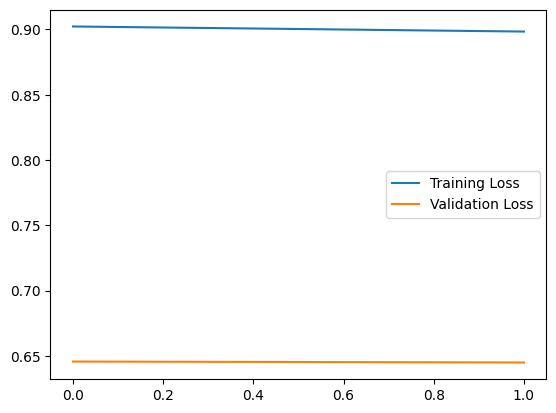

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/65, Train Loss: 0.8949, Val Loss: 0.6444


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/65, Train Loss: 0.8928, Val Loss: 0.6438


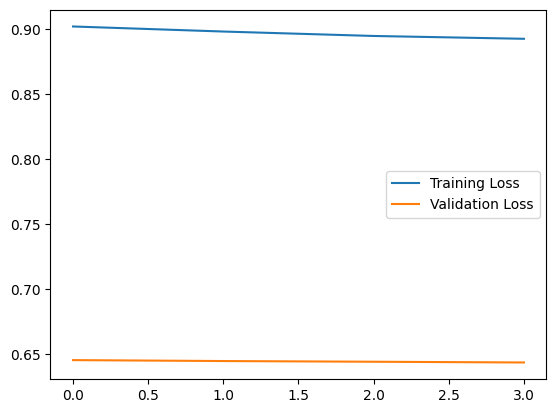

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/65, Train Loss: 0.8890, Val Loss: 0.6433


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/65, Train Loss: 0.8864, Val Loss: 0.6428


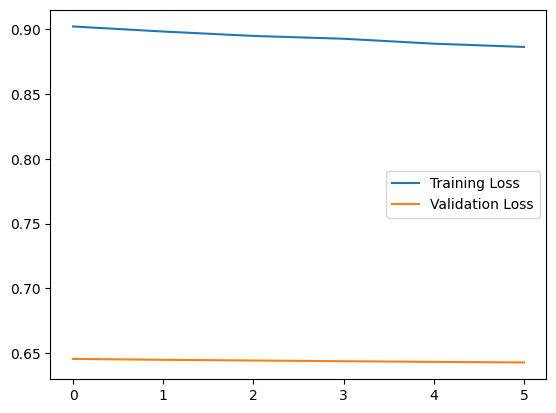

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/65, Train Loss: 0.8829, Val Loss: 0.6424


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/65, Train Loss: 0.8791, Val Loss: 0.6420


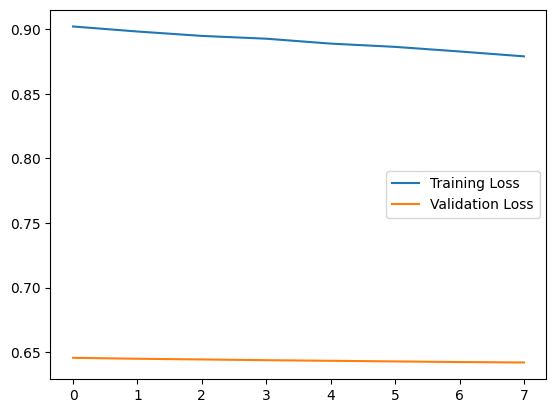

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/65, Train Loss: 0.8758, Val Loss: 0.6417


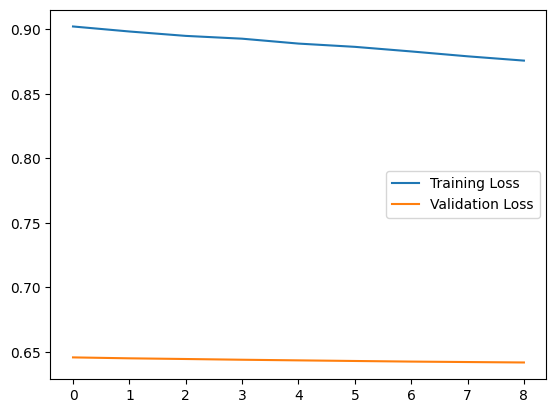

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/65, Train Loss: 0.8732, Val Loss: 0.6414


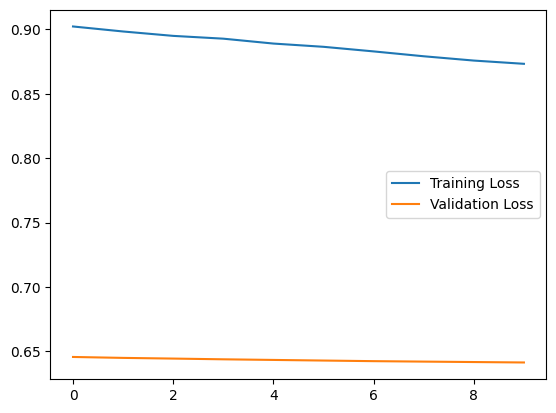

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/65, Train Loss: 0.8694, Val Loss: 0.6410


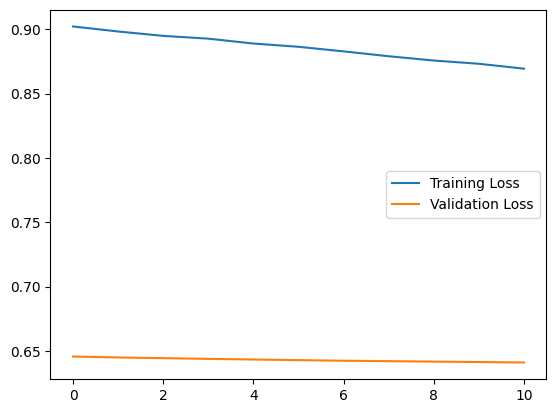

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/65, Train Loss: 0.8670, Val Loss: 0.6407


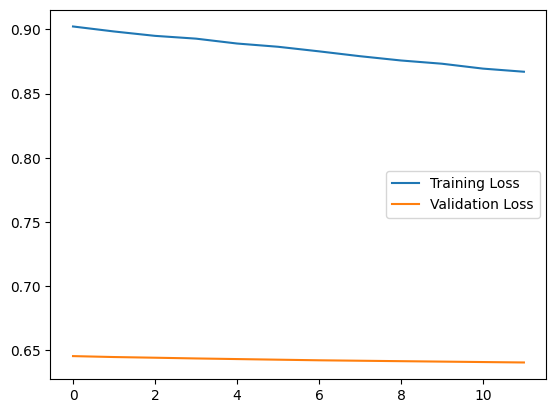

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/65, Train Loss: 0.8629, Val Loss: 0.6404


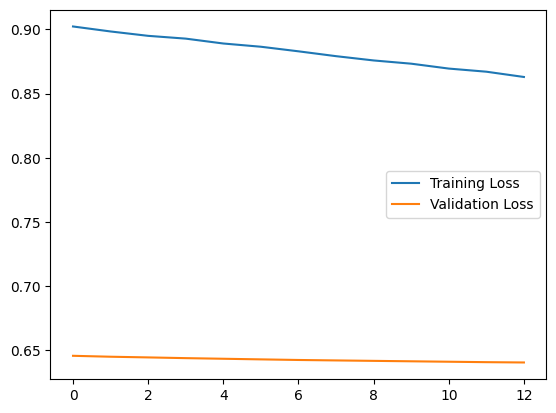

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/65, Train Loss: 0.8593, Val Loss: 0.6401


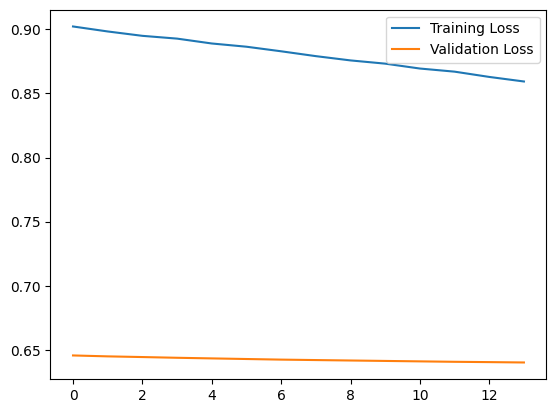

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/65, Train Loss: 0.8558, Val Loss: 0.6399


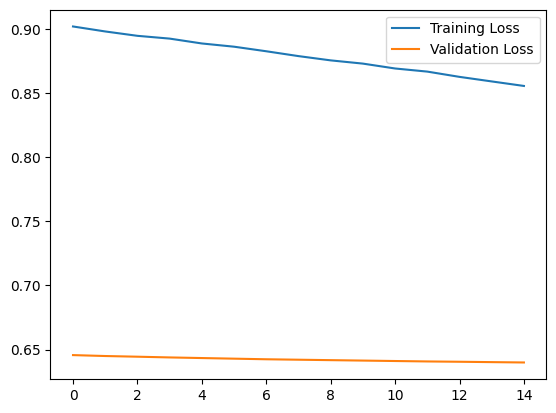

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/65, Train Loss: 0.8541, Val Loss: 0.6397


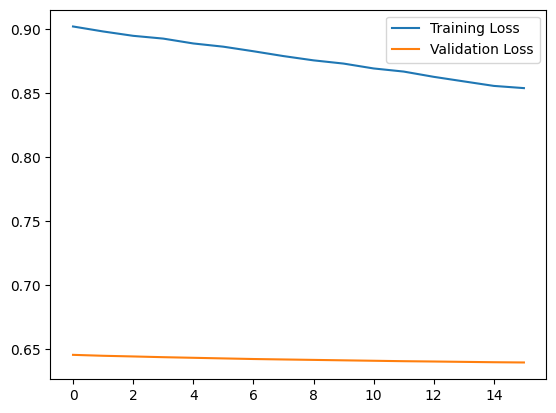

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/65, Train Loss: 0.8504, Val Loss: 0.6393


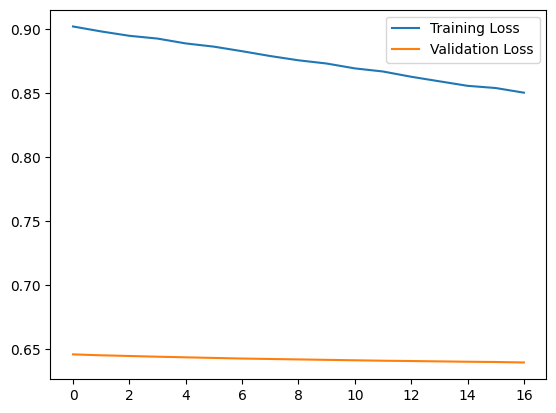

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/65, Train Loss: 0.8467, Val Loss: 0.6390


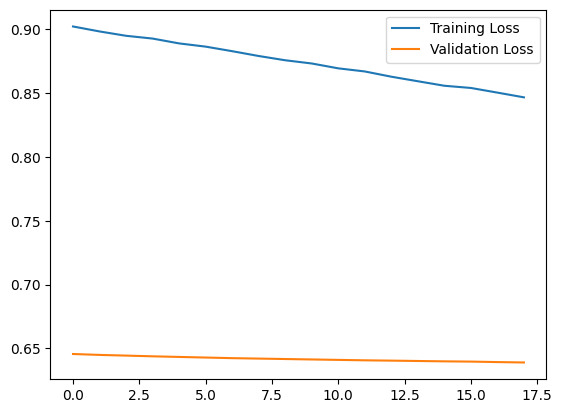

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/65, Train Loss: 0.8448, Val Loss: 0.6387


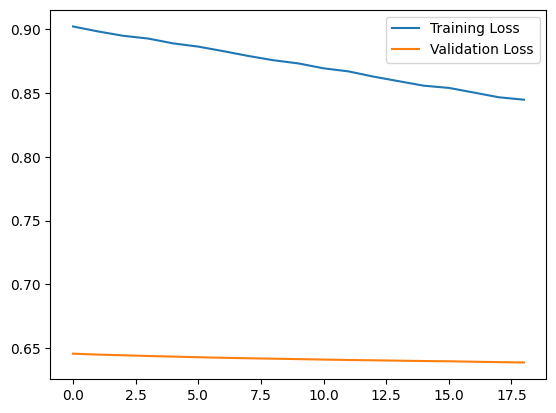

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/65, Train Loss: 0.8408, Val Loss: 0.6383


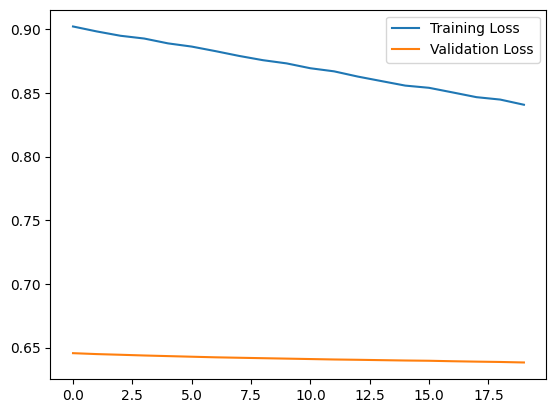

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/65, Train Loss: 0.8398, Val Loss: 0.6381


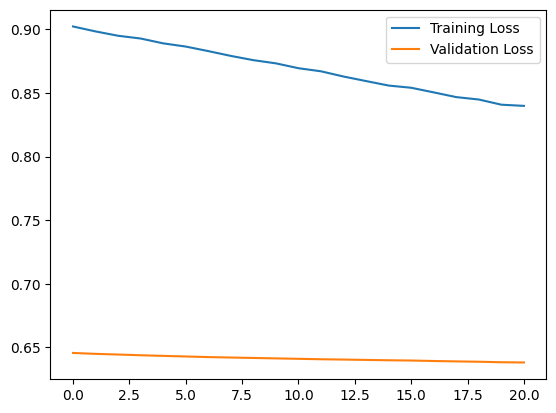

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/65, Train Loss: 0.8383, Val Loss: 0.6378


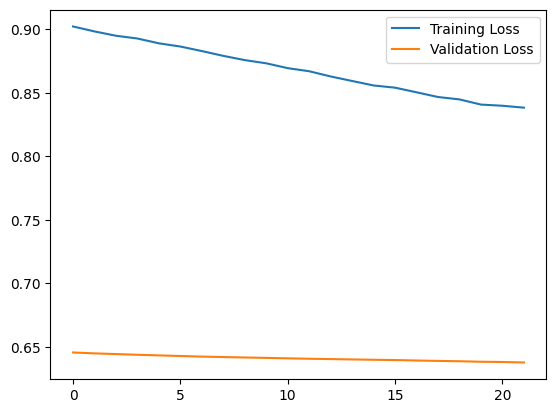

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/65, Train Loss: 0.8348, Val Loss: 0.6374


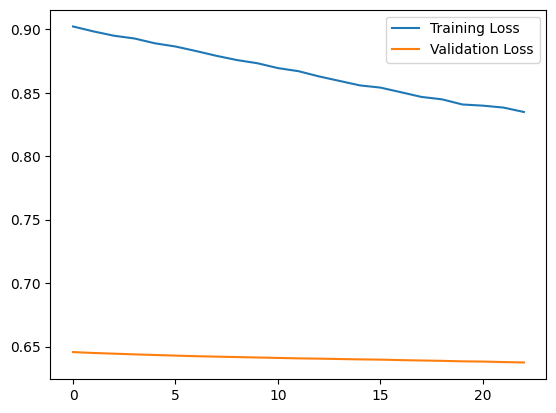

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/65, Train Loss: 0.8317, Val Loss: 0.6371


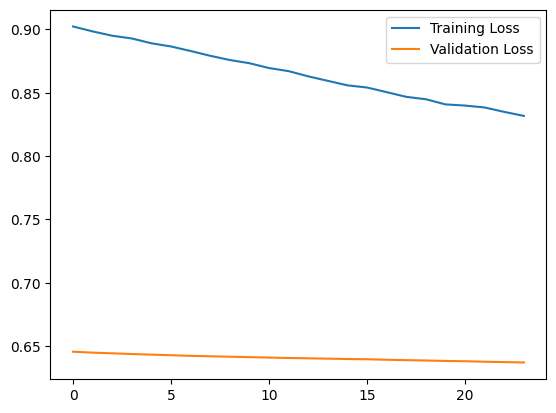

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/65, Train Loss: 0.8312, Val Loss: 0.6368


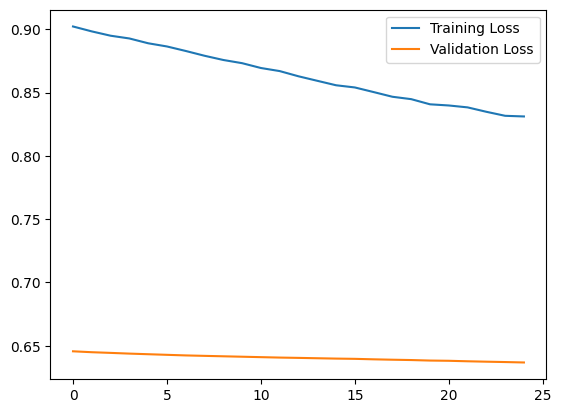

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/65, Train Loss: 0.8289, Val Loss: 0.6365


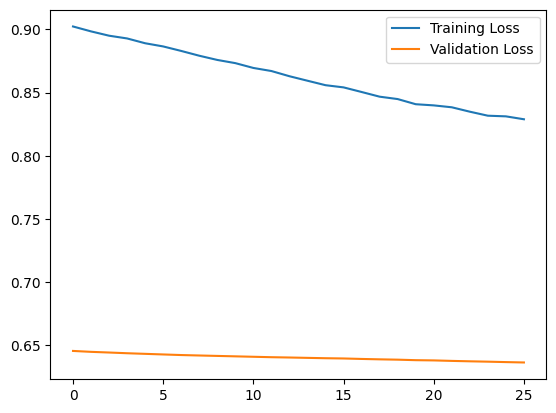

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/65, Train Loss: 0.8271, Val Loss: 0.6362


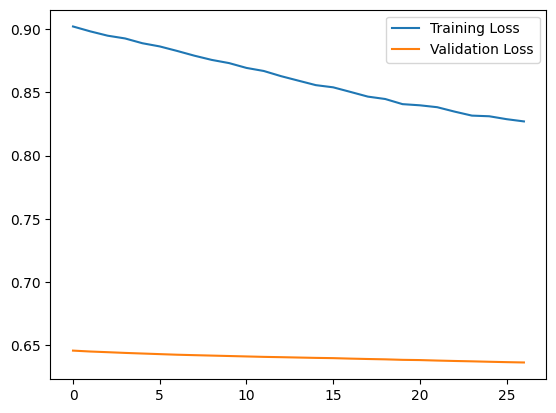

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/65, Train Loss: 0.8270, Val Loss: 0.6360


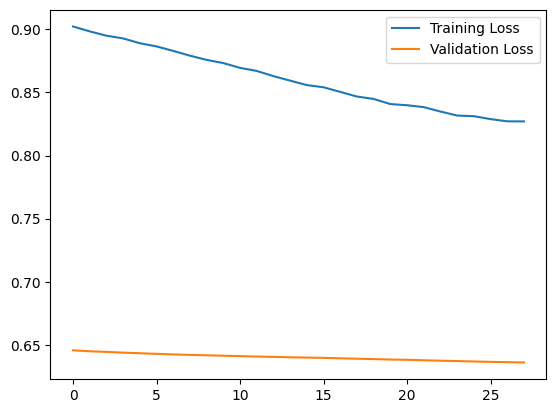

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/65, Train Loss: 0.8249, Val Loss: 0.6358


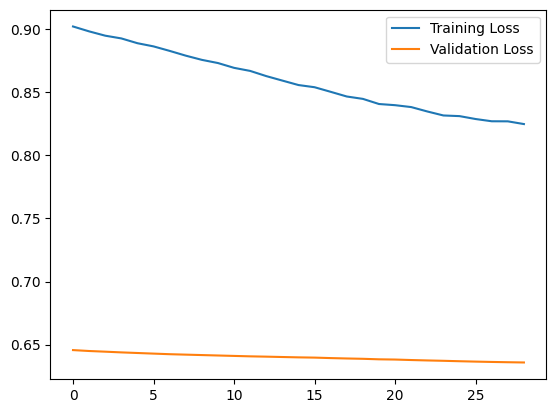

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/65, Train Loss: 0.8238, Val Loss: 0.6356


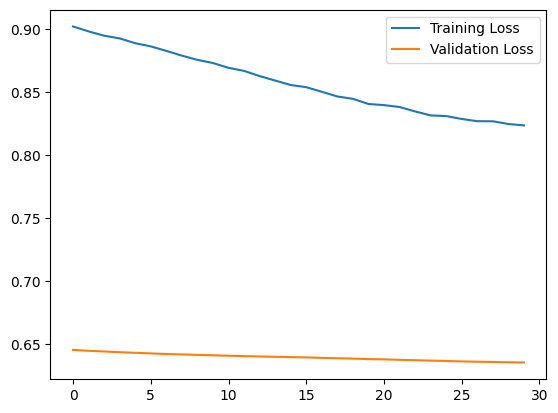

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/65, Train Loss: 0.8233, Val Loss: 0.6354


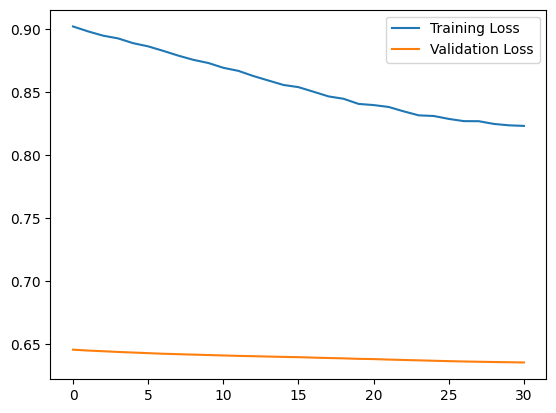

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/65, Train Loss: 0.8218, Val Loss: 0.6353


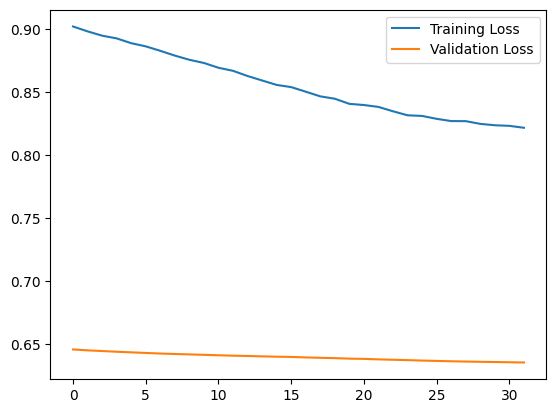

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/65, Train Loss: 0.8198, Val Loss: 0.6350


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/65, Train Loss: 0.8204, Val Loss: 0.6349


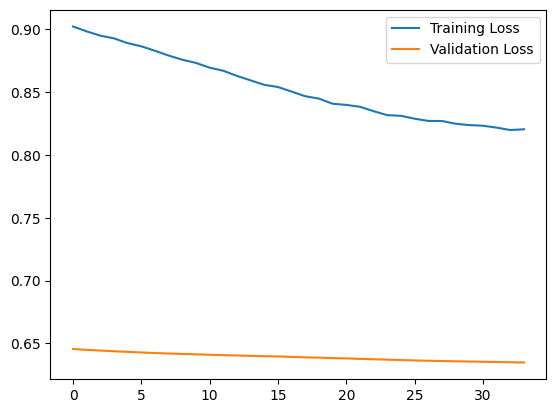

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/65, Train Loss: 0.8199, Val Loss: 0.6347


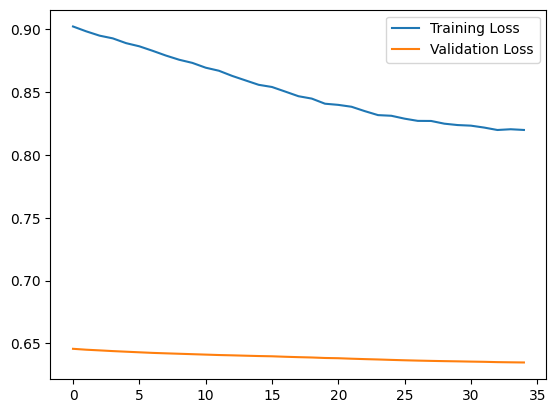

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 36/65, Train Loss: 0.8189, Val Loss: 0.6346


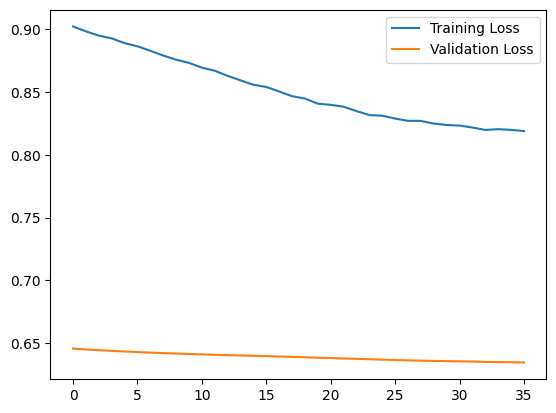

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 37/65, Train Loss: 0.8181, Val Loss: 0.6344


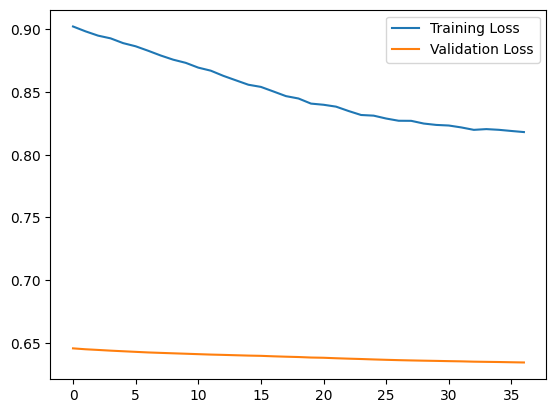

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 38/65, Train Loss: 0.8179, Val Loss: 0.6343


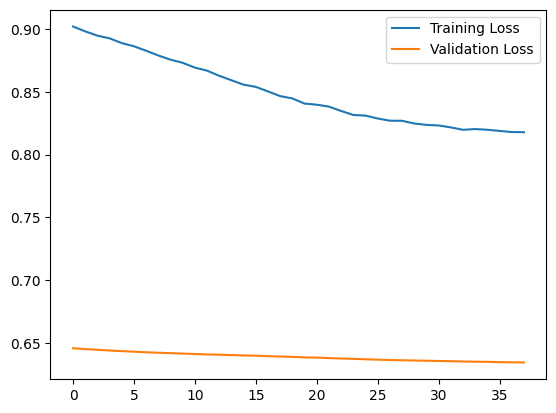

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 39/65, Train Loss: 0.8158, Val Loss: 0.6341


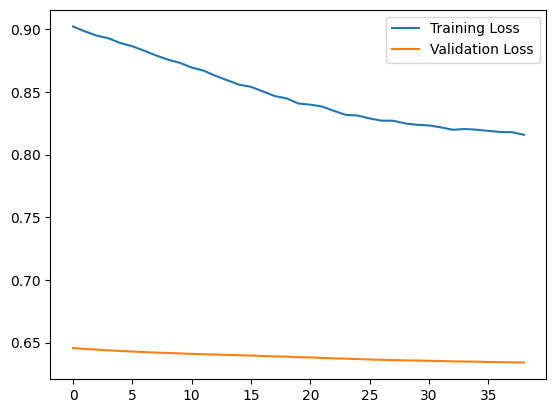

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 40/65, Train Loss: 0.8164, Val Loss: 0.6340


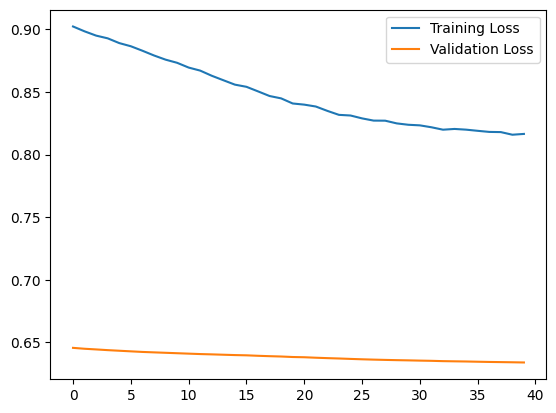

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 41/65, Train Loss: 0.8163, Val Loss: 0.6338


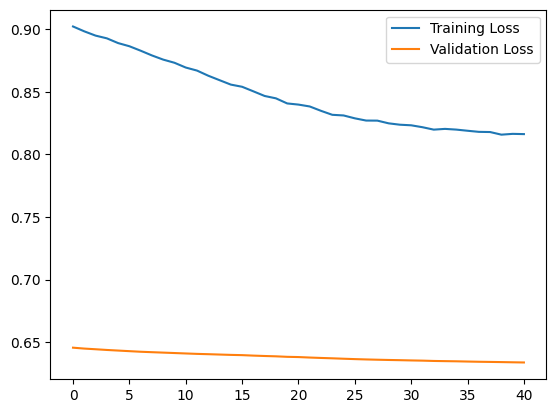

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 42/65, Train Loss: 0.8148, Val Loss: 0.6337


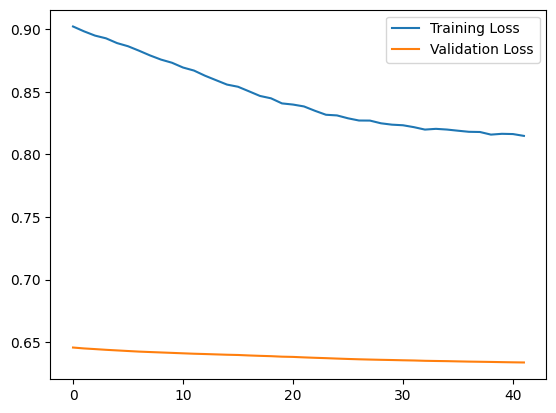

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 43/65, Train Loss: 0.8131, Val Loss: 0.6336


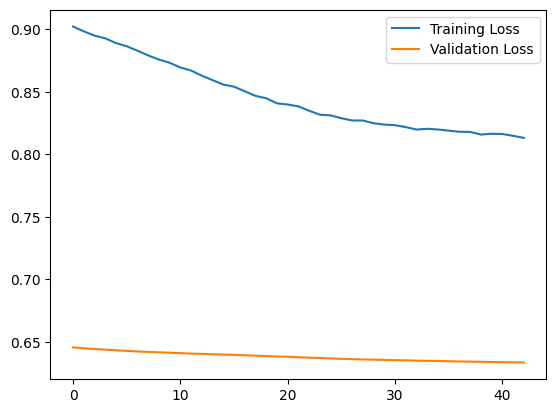

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 44/65, Train Loss: 0.8150, Val Loss: 0.6335


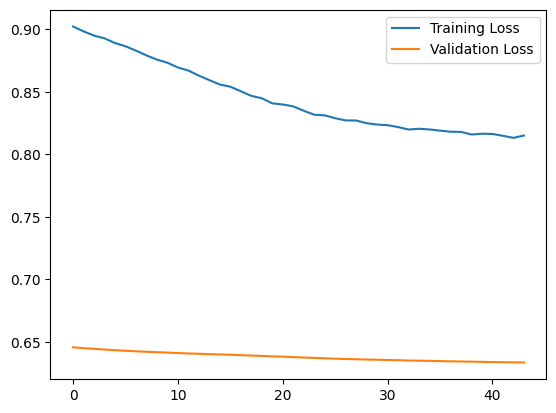

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 45/65, Train Loss: 0.8140, Val Loss: 0.6334


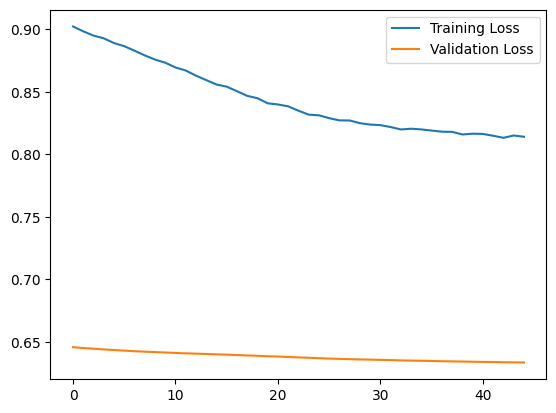

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 46/65, Train Loss: 0.8135, Val Loss: 0.6333


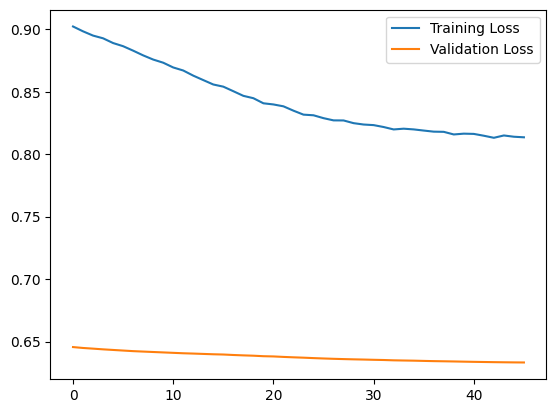

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 47/65, Train Loss: 0.8131, Val Loss: 0.6332


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 48/65, Train Loss: 0.8139, Val Loss: 0.6331


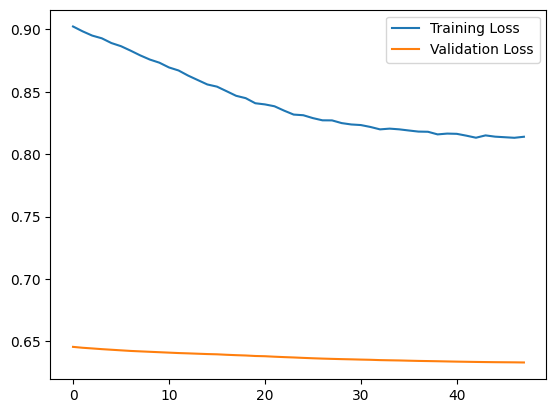

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 49/65, Train Loss: 0.8136, Val Loss: 0.6331


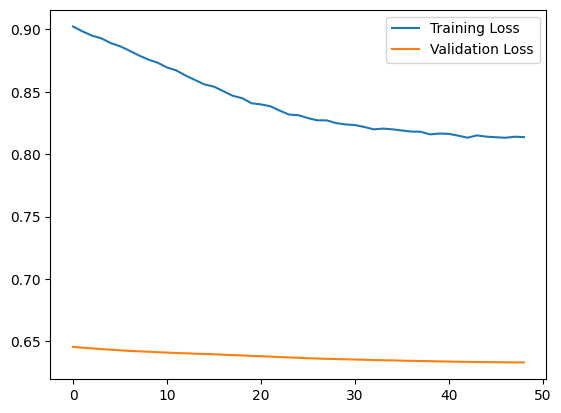

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 50/65, Train Loss: 0.8129, Val Loss: 0.6330


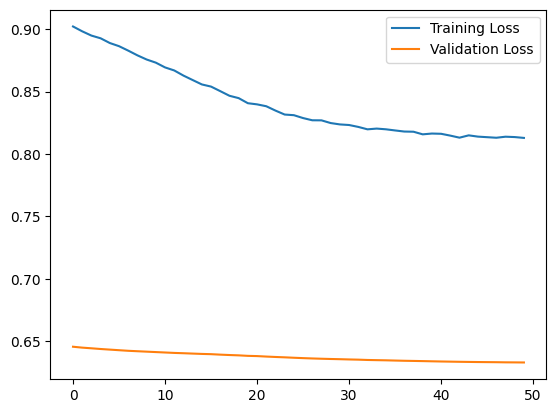

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 51/65, Train Loss: 0.8141, Val Loss: 0.6329


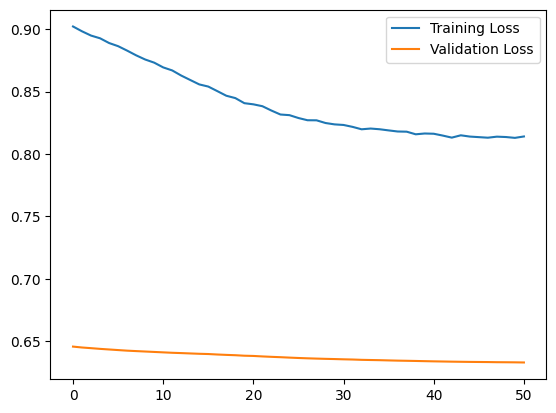

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 52/65, Train Loss: 0.8128, Val Loss: 0.6328


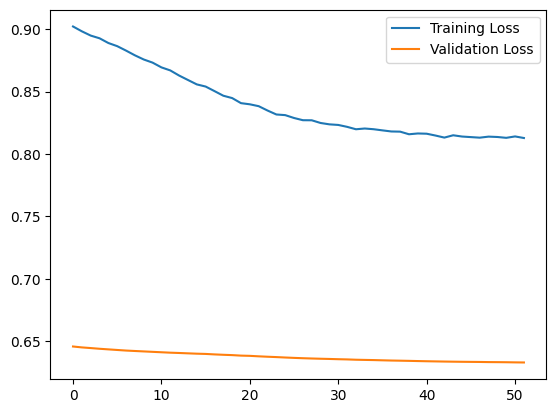

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 53/65, Train Loss: 0.8122, Val Loss: 0.6328


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 54/65, Train Loss: 0.8122, Val Loss: 0.6327


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 55/65, Train Loss: 0.8123, Val Loss: 0.6326


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 56/65, Train Loss: 0.8112, Val Loss: 0.6326


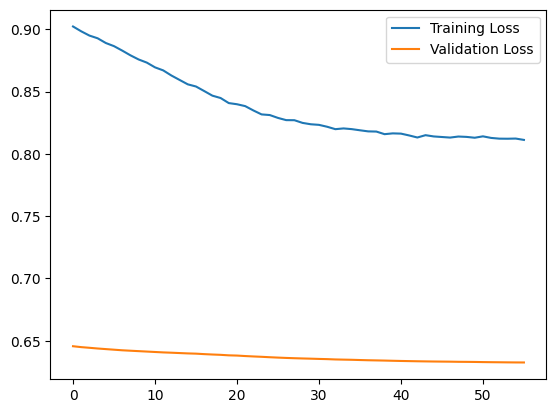

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 57/65, Train Loss: 0.8122, Val Loss: 0.6325


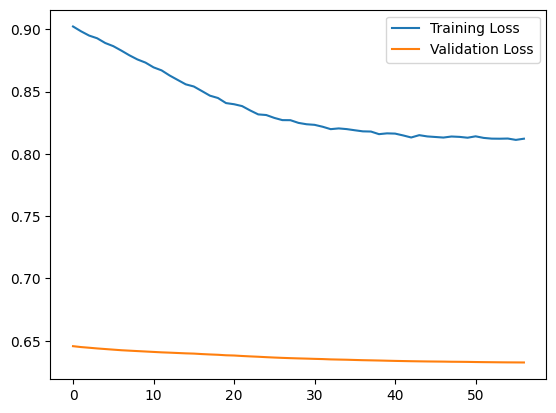

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 58/65, Train Loss: 0.8099, Val Loss: 0.6325


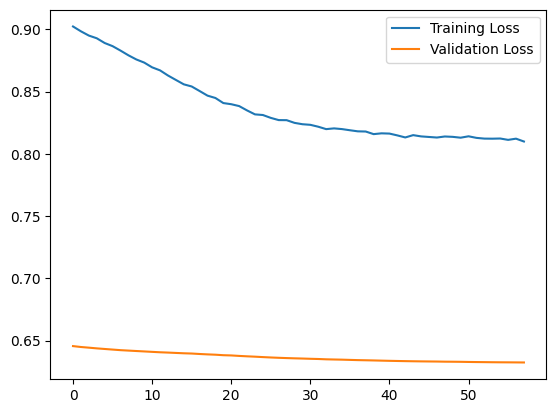

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 59/65, Train Loss: 0.8110, Val Loss: 0.6324


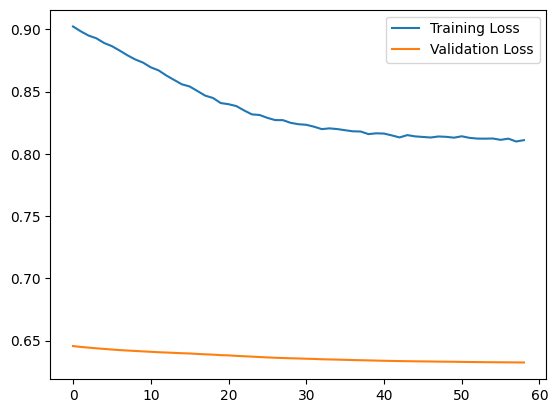

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 60/65, Train Loss: 0.8112, Val Loss: 0.6324


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 61/65, Train Loss: 0.8115, Val Loss: 0.6324


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 62/65, Train Loss: 0.8119, Val Loss: 0.6323


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 63/65, Train Loss: 0.8100, Val Loss: 0.6323


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 64/65, Train Loss: 0.8109, Val Loss: 0.6323


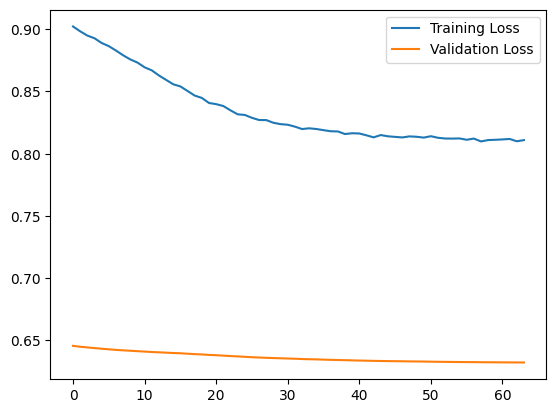

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch 65/65, Train Loss: 0.8108, Val Loss: 0.6322


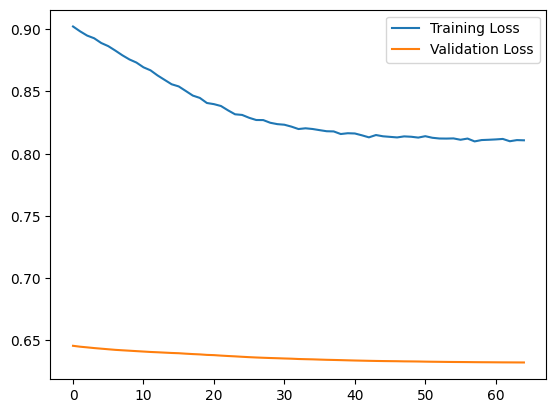

In [ ]:
model = SimpleModelCNN(input_size=32, hidden_size=64, output_size=CFG.BATCH_SIZE, num_layers=1) #?
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_loss_SimpleCNN, val_loss_SimpleCNN = train_model(model, criterion, optimizer, train_loader, test_loader, 65)

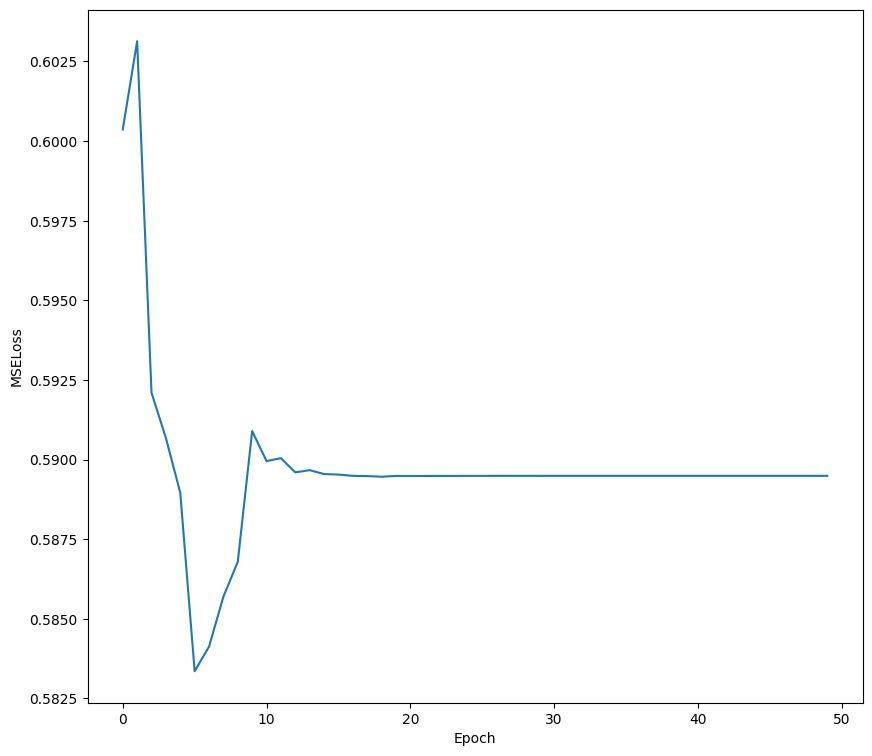

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(val_loss_SimpleCNN)
plt.xlabel('Epoch')
plt.ylabel('MSELoss')
plt.show()

In [ ]:
print(np.mean(val_loss_SimpleCNN))

0.6363835149453236


In [ ]:
summary(model, (14, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 14]             128
              GELU-2               [-1, 32, 14]               0
         MaxPool1d-3                [-1, 32, 7]               0
            Conv1d-4                [-1, 64, 7]           6,208
              GELU-5                [-1, 64, 7]               0
         MaxPool1d-6                [-1, 64, 3]               0
            Linear-7                   [-1, 32]           6,176
              GELU-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.05
Estimated Total Size (MB): 0.07
---------------------------------------------

torch.Size([1, 14, 1])
0: [], tensor([[-0.1082]])
=====
torch.Size([1, 14, 1])
1: [-0.10824039578437805], tensor([[0.9523]])
=====
torch.Size([1, 14, 1])
2: [-0.10824039578437805, 0.9522625803947449], tensor([[1.1064]])
=====
torch.Size([1, 14, 1])
3: [-0.10824039578437805, 0.9522625803947449, 1.1064307689666748], tensor([[0.1069]])
=====
torch.Size([1, 14, 1])
4: [-0.10824039578437805, 0.9522625803947449, 1.1064307689666748, 0.10693037509918213], tensor([[0.1850]])
=====
torch.Size([1, 14, 1])
5: [-0.10824039578437805, 0.9522625803947449, 1.1064307689666748, 0.10693037509918213, 0.18497762084007263], tensor([[2.0194]])
=====
torch.Size([1, 14, 1])
6: [-0.10824039578437805, 0.9522625803947449, 1.1064307689666748, 0.10693037509918213, 0.18497762084007263, 2.019425868988037], tensor([[-0.5838]])
=====
torch.Size([1, 14, 1])
7: [-0.10824039578437805, 0.9522625803947449, 1.1064307689666748, 0.10693037509918213, 0.18497762084007263, 2.019425868988037, -0.5837782621383667], tensor([[-0.7984]

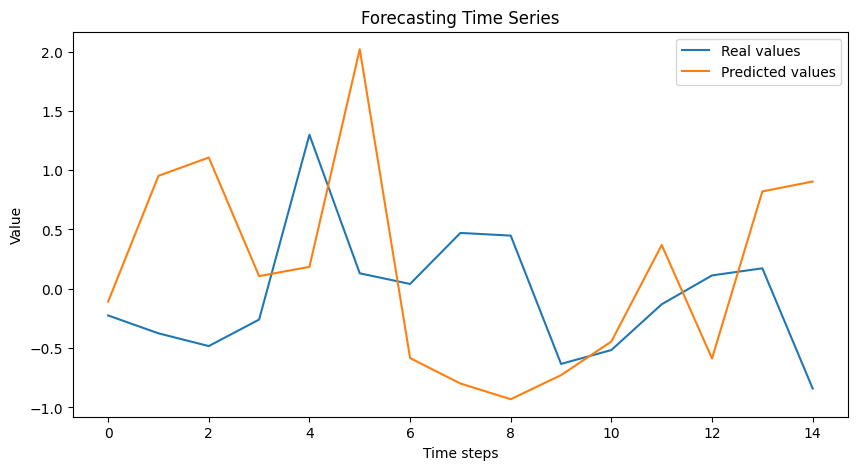

In [ ]:
input_data, real_value = test_dataset[-15:]  # Last 15 steps as input
real_value = real_value.numpy()
predicted_values = forecast(model, input_data, steps_ahead=15)
plot_forecast(real_value, predicted_values)

In [ ]:
gc.collect()

1754

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    Custom dataset for time series forecasting with TCN.

    Args:
        data (np.ndarray): The time series data.
        seq_len (int): The length of each sequence.
        pred_len (int): The length of the prediction horizon.
        stride (int): The stride between sequences.
        target_column (int): The index of the column to forecast.
    """

    def __init__(self, data, seq_len, pred_len, stride=1, target_column=0):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.stride = stride
        self.target_column = target_column

        # Calculate the number of sequences
        self.num_sequences = (len(data) - seq_len - pred_len) // stride + 1

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Returns a single sequence and its corresponding target.

        Args:
            idx (int): The index of the sequence.

        Returns:
            tuple: A tuple containing the sequence and target.
        """

        # Calculate the starting index for the sequence
        start_idx = idx * self.stride

        # Extract the sequence
        sequence = self.data[start_idx:start_idx + self.seq_len]

        # Extract the target
        target = self.data[start_idx + self.seq_len:start_idx + self.seq_len + self.pred_len, self.target_column]

        # Convert to PyTorch tensors
        sequence = torch.from_numpy(sequence.astype(np.float32))
        target = torch.from_numpy(target.astype(np.float32))

        return sequence, target

In [ ]:
train_size = int(0.8 * len(data))  # 80% for training
train_data, test_data = data[:train_size], data[train_size:]

# Create datasets for train and test sets
train_dataset = TimeSeriesDataset(train_data, seq_len=20, pred_len=10, stride=5)
test_dataset = TimeSeriesDataset(test_data, seq_len=20, pred_len=10, stride=5)

# Create data loaders for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'TimeSeriesDataset' is not defined

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# Define TCN Architecture
class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                        padding=(kernel_size - 1) * dilation_size, dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.fc1 = nn.Linear(num_channels[-1], 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.transpose(1, 2)  # Shape: [batch_size, input_dim, sequence_length]
        out = self.network(x)
        out = out[:, :, -1]  # Extract the last time step
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [ ]:
model = TCN(input_dim=1, num_channels=[16, 32, 64], kernel_size=3, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_loss, train_targets, train_predictions = train_loop(model, train_loader, criterion, optimizer, 0, 20)

  0%|          | 0/21 [00:00<?, ?it/s]

InvalidIndexError: (slice(20, 30, None), 0)